# MATH-500 Dataset Evaluation

This notebook evaluates various local models on the MATH-500 dataset from HuggingFace.
The dataset contains 500 mathematical problems across different subjects and difficulty levels.

## Setup and Dependencies

In [1]:
%pip install pandas numpy datasets matplotlib seaborn tqdm tiktoken

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import json
import re
from typing import List, Dict, Any, Optional, Tuple
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# For local model inference
import requests
import subprocess
import os

# For token counting
try:
    import tiktoken
    TIKTOKEN_AVAILABLE = True
except ImportError:
    TIKTOKEN_AVAILABLE = False
    print("Warning: tiktoken not available. Token counting will use approximate word-based method.")

# Token counting utilities
class TokenCounter:
    """Utility class for counting tokens in text"""
    
    def __init__(self, model_name: str = "gpt-4"):
        """Initialize token counter with specified model encoding"""
        self.model_name = model_name
        if TIKTOKEN_AVAILABLE:
            try:
                # Try to get exact encoding for the model
                self.encoding = tiktoken.encoding_for_model(model_name)
            except KeyError:
                # Fallback to cl100k_base encoding (used by GPT-4, GPT-3.5-turbo)
                self.encoding = tiktoken.get_encoding("cl100k_base")
        else:
            self.encoding = None
    
    def count_tokens(self, text: str) -> int:
        """Count tokens in text"""
        if not text:
            return 0
            
        if self.encoding:
            return len(self.encoding.encode(text))
        else:
            # Fallback: approximate token count (roughly 1 token per 4 characters)
            return max(1, len(text) // 4)
    
    def count_tokens_batch(self, texts: List[str]) -> List[int]:
        """Count tokens for multiple texts efficiently"""
        return [self.count_tokens(text) for text in texts]

# Global token counter instance
token_counter = TokenCounter()

/Users/pasta/workspace/llm-chinese-english/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading

In [3]:
# Load the MATH-500 dataset
print("Loading MATH-500 dataset...")
dataset = load_dataset("HuggingFaceH4/MATH-500", split="test")
df = dataset.to_pandas()

# Sort the DataFrame by "level"
df = df.sort_values(by="level").reset_index(drop=True)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Loading MATH-500 dataset...
Dataset loaded successfully!
Shape: (500, 6)
Columns: ['problem', 'solution', 'answer', 'subject', 'level', 'unique_id']

First few rows:


,problem,solution,answer,subject,level,unique_id
0,"A curve is parameterized by\n\[(x,y) = (t^3 + ...","At $t = 2,$ $(x,y) = (2^3 + 7, -3 \cdot 2^2 - ...","(15,-29)",Precalculus,1,test/precalculus/43.json
1,If a snack-size tin of peaches has $40$ calori...,If 40 calories is equal to $2\%=\frac{2}{100}=...,2000,Algebra,1,test/algebra/24.json
2,$441+2(21)(19)+361=x$. Solve for $x$.,"We note that $361=19^2$ and $441=21^2$, so $x=...",1600,Algebra,1,test/algebra/1937.json
3,"Two candidates, Dan and Donald, run for class ...",The probability that Dan wins is $\frac12$. Th...,\frac14,Counting & Probability,1,test/counting_and_probability/14.json
4,"Hillary has eleven coins, all dimes and nickel...",Let the number of dimes Hillary has be $d$ and...,7,Algebra,1,test/algebra/2199.json


In [4]:
# Explore dataset structure
print("Dataset Info:")
print(f"Total problems: {len(df)}")
print(f"Subjects: {df['subject'].value_counts().to_dict()}")
print(f"Difficulty levels: {df['level'].value_counts().sort_index().to_dict()}")

# Sample problem
print("\n" + "="*50)
print("Sample Problem:")
sample = df.iloc[0]
print(f"Subject: {sample['subject']}")
print(f"Level: {sample['level']}")
print(f"Problem: {sample['problem'][:200]}...")
print(f"Answer: {sample['answer']}")

Dataset Info:
Total problems: 500
Subjects: {'Algebra': 124, 'Intermediate Algebra': 97, 'Prealgebra': 82, 'Number Theory': 62, 'Precalculus': 56, 'Geometry': 41, 'Counting & Probability': 38}
Difficulty levels: {1: 43, 2: 90, 3: 105, 4: 128, 5: 134}

Sample Problem:
Subject: Precalculus
Level: 1
Problem: A curve is parameterized by
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]Find the point the curve passes through at $t = 2.$...
Answer: (15,-29)


## Model Interface Classes

In [5]:
class BaseModelInterface:
    """Base class for model interfaces"""
    
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.token_counter = TokenCounter(model_name)
    
    def generate_response(self, prompt: str) -> Tuple[str, Dict[str, int]]:
        """Generate response from the model and return token usage"""
        raise NotImplementedError
    
    def is_available(self) -> bool:
        """Check if model is available"""
        raise NotImplementedError


class OllamaInterface(BaseModelInterface):
    """Interface for Ollama models"""
    
    def __init__(self, model_name: str, base_url: str = "http://localhost:11434"):
        super().__init__(model_name)
        self.base_url = base_url
        self.api_url = f"{base_url}/api/generate"
    
    def generate_response(self, prompt: str, max_tokens: int = 8192, temperature: float = 0.1) -> Tuple[str, Dict[str, int]]:
        """Generate response using Ollama API"""
        try:
            payload = {
                "model": self.model_name,
                "prompt": prompt,
                "stream": False,
                "options": {
                    "num_predict": max_tokens,
                    "temperature": temperature
                }
            }
            
            response = requests.post(self.api_url, json=payload, timeout=300)
            response.raise_for_status()
            
            result = response.json()
            response_text = result.get('response', '').strip()
            
            # Calculate token usage
            input_tokens = self.token_counter.count_tokens(prompt)
            output_tokens = self.token_counter.count_tokens(response_text)
            
            token_usage = {
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'total_tokens': input_tokens + output_tokens
            }
            
            return response_text, token_usage
            
        except Exception as e:
            print(f"Error generating response with {self.model_name}: {e}")
            return "", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
    
    def is_available(self) -> bool:
        """Check if Ollama model is available"""
        try:
            response = requests.get(f"{self.base_url}/api/tags", timeout=10)
            if response.status_code == 200:
                models = response.json().get('models', [])
                return any(model['name'].startswith(self.model_name) for model in models)
            return False
        except:
            return False


class LMStudioInterface(BaseModelInterface):
    """Interface for LM Studio models"""
    
    def __init__(self, model_name: str, base_url: str = "http://localhost:1234"):
        super().__init__(model_name)
        self.base_url = base_url
        self.chat_api_url = f"{base_url}/v1/chat/completions"
        self.completions_api_url = f"{base_url}/v1/completions"
    
    def generate_response(self, prompt: str, max_tokens: int = 8192, temperature: float = 0.1) -> Tuple[str, Dict[str, int]]:
        """Generate response using LM Studio API"""
        try:
            # Try chat completions API first (OpenAI-compatible)
            chat_payload = {
                "model": self.model_name,
                "messages": [
                    {"role": "user", "content": prompt}
                ],
                "max_tokens": max_tokens,
                "temperature": temperature,
                "stream": False
            }
            
            response = requests.post(self.chat_api_url, json=chat_payload, timeout=300)
            response_text = ""
            token_usage = {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
            
            if response.status_code == 200:
                result = response.json()
                response_text = result['choices'][0]['message']['content'].strip()
                
                # Try to get token usage from API response
                if 'usage' in result:
                    usage = result['usage']
                    token_usage = {
                        'input_tokens': usage.get('prompt_tokens', 0),
                        'output_tokens': usage.get('completion_tokens', 0),
                        'total_tokens': usage.get('total_tokens', 0)
                    }
                else:
                    # Fallback to manual counting
                    input_tokens = self.token_counter.count_tokens(prompt)
                    output_tokens = self.token_counter.count_tokens(response_text)
                    token_usage = {
                        'input_tokens': input_tokens,
                        'output_tokens': output_tokens,
                        'total_tokens': input_tokens + output_tokens
                    }
                
                return response_text, token_usage
            
            # Fallback to completions API
            completions_payload = {
                "model": self.model_name,
                "prompt": prompt,
                "max_tokens": max_tokens,
                "temperature": temperature,
                "stream": False
            }
            
            response = requests.post(self.completions_api_url, json=completions_payload, timeout=300)
            response.raise_for_status()
            
            result = response.json()
            response_text = result['choices'][0]['text'].strip()
            
            # Try to get token usage from API response
            if 'usage' in result:
                usage = result['usage']
                token_usage = {
                    'input_tokens': usage.get('prompt_tokens', 0),
                    'output_tokens': usage.get('completion_tokens', 0),
                    'total_tokens': usage.get('total_tokens', 0)
                }
            else:
                # Fallback to manual counting
                input_tokens = self.token_counter.count_tokens(prompt)
                output_tokens = self.token_counter.count_tokens(response_text)
                token_usage = {
                    'input_tokens': input_tokens,
                    'output_tokens': output_tokens,
                    'total_tokens': input_tokens + output_tokens
                }
            
            return response_text, token_usage
            
        except Exception as e:
            print(f"Error generating response with {self.model_name}: {e}")
            return "", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
    
    def is_available(self) -> bool:
        """Check if LM Studio is available"""
        try:
            response = requests.get(f"{self.base_url}/v1/models", timeout=10)
            return response.status_code == 200
        except:
            return False

## Test LM Studio Inference

**⚠️ STOP HERE TO TEST LM STUDIO INFERENCE**

Before running the full evaluation, let's test if LM Studio is working properly:

In [6]:
# Test LM Studio connection and inference
print("Testing LM Studio connection...")

# Create LM Studio interface instance
lm_studio = LMStudioInterface("test-model")  # Model name doesn't matter for testing availability

# Check if LM Studio is running
if lm_studio.is_available():
    print("✅ LM Studio is running and accessible!")
    
    # Get actual model name from LM Studio
    try:
        response = requests.get("http://localhost:1234/v1/models", timeout=10)
        if response.status_code == 200:
            models = response.json().get('data', [])
            if models:
                actual_model = models[0]['id']  # Use the first available model
                print(f"Found model: {actual_model}")
                
                # Create interface with actual model name
                lm_studio_actual = LMStudioInterface(actual_model)
                
                # Test a simple math problem
                test_problem = "What is 2 + 2?"
                test_prompt = f"You are a mathematical expert. Solve this problem: {test_problem}\n\nAnswer:"
                
                print(f"\nTesting with simple problem: {test_problem}")
                print("Generating response...")
                
                response_text, token_usage = lm_studio_actual.generate_response(test_prompt, max_tokens=100, temperature=0.1)
                
                if response_text:
                    print(f"✅ Response received:")
                    print(f"'{response_text[:200]}{'...' if len(response_text) > 200 else ''}'")
                    print(f"\n📊 Token Usage:")
                    print(f"   Input tokens: {token_usage['input_tokens']}")
                    print(f"   Output tokens: {token_usage['output_tokens']}")
                    print(f"   Total tokens: {token_usage['total_tokens']}")
                    print("\n🎉 LM Studio inference and token counting are working!")
                else:
                    print("❌ No response received. Check LM Studio model loading.")
            else:
                print("❌ No models found in LM Studio.")
        else:
            print("❌ Could not retrieve model list from LM Studio.")
    except Exception as e:
        print(f"❌ Error testing LM Studio: {e}")
        
else:
    print("❌ LM Studio is not available. Please check:")
    print("   1. LM Studio is running")
    print("   2. A model is loaded")
    print("   3. Server is running on http://localhost:1234")
    print("   4. API server is enabled in LM Studio settings")

print("\n" + "="*60)
print("If LM Studio is working, you can proceed with the evaluation.")
print("If not, fix the issues above before continuing.")
print("="*60)

Testing LM Studio connection...
✅ LM Studio is running and accessible!
Found model: microsoft/phi-4-mini-reasoning

Testing with simple problem: What is 2 + 2?
Generating response...
✅ Response received:
'<think>
Okay, let me try to figure out what 2 plus 2 is. Hmm, addition problem. So, I know that adding two numbers means combining their quantities. If I have 2 apples and someone gives me another 2 a...'

📊 Token Usage:
   Input tokens: 38
   Output tokens: 99
   Total tokens: 137

🎉 LM Studio inference and token counting are working!

If LM Studio is working, you can proceed with the evaluation.
If not, fix the issues above before continuing.


## Evaluation Framework

In [7]:
def create_math_prompt(problem: str) -> str:
    """Create a structured prompt for mathematical problem solving"""
    return f"""You are a mathematical expert. Solve the following problem step by step.

Problem: {problem}

Please provide a clear step-by-step solution and put your final answer in \\boxed{{}}.

Solution:"""


def create_judge_prompt(expected_answer: str, predicted_answer: str) -> str:
    """Create a prompt for LLM-as-judge validation"""
    return f"""You are a mathematical expert judge. Your task is to determine if two mathematical answers are equivalent, even if they have different formatting.

Are these equivalent:
💯 Expected Answer: {expected_answer}
🤖 Model Answer: {predicted_answer}

Consider the following as equivalent:
- Different LaTeX formatting (e.g., \\frac{{1}}{{2}} vs 0.5 vs 1/2)
- Different text formatting (e.g., \\text{{(E)}} vs E vs (E))
- Different spacing or punctuation
- Mathematically equivalent expressions (e.g., 2*3 vs 6)
- Different coordinate formats (e.g., (3, π/2) vs \\left( 3, \\frac{{\\pi}}{{2}} \\right))

Provide your answer in \\boxed{{}}, it should be exactly "yes" or "no"."""


def extract_answer(response: str) -> str:
    """Extract the final answer from model response"""
    # First priority: Look for boxed answers with better nested brace handling
    def find_boxed_content(text):
        """Find content inside \\boxed{...} handling nested braces correctly"""
        start_pattern = r'\\boxed\{'
        matches = []
        
        import re
        for match in re.finditer(start_pattern, text):
            start_pos = match.end() - 1  # Position of the opening brace
            brace_count = 0
            current_pos = start_pos
            
            # Find the matching closing brace
            while current_pos < len(text):
                if text[current_pos] == '{':
                    brace_count += 1
                elif text[current_pos] == '}':
                    brace_count -= 1
                    if brace_count == 0:
                        # Found the matching closing brace
                        content = text[start_pos + 1:current_pos]
                        matches.append(content)
                        break
                current_pos += 1
        
        return matches
    
    boxed_matches = find_boxed_content(response)
    if boxed_matches:
        return boxed_matches[-1].strip()  # Return the last boxed answer
    
    # Common patterns for final answers (fallback)
    patterns = [
        r'(?:final answer|answer|result)(?:\s*is)?[\s:]*(.+?)(?:\.|$|\n)',
        r'(?:therefore|thus|so)[\s,]*(.+?)(?:\.|$|\n)',
        r'\$(.+?)\$',  # LaTeX format
        r'(?:=|equals?)[\s]*(.+?)(?:\.|$|\n)',
    ]
    
    response_lower = response.lower().strip()
    
    for pattern in patterns:
        matches = re.findall(pattern, response_lower, re.IGNORECASE | re.MULTILINE)
        if matches:
            # Return the last match (usually the final answer)
            return matches[-1].strip()
    
    # If no pattern matches, return the last line that might contain an answer
    lines = [line.strip() for line in response.split('\n') if line.strip()]
    if lines:
        return lines[-1]
    
    return response.strip()


def normalize_answer(answer: str) -> str:
    """Normalize answer for comparison"""
    if not answer:
        return ""
    
    # Remove common formatting but preserve LaTeX structure
    answer = answer.strip()
    answer = re.sub(r'^\$|\$$', '', answer)  # Remove outer dollar signs only
    answer = re.sub(r'\\text\{([^}]*)\}', r'\1', answer)  # Remove \text{} LaTeX
    answer = re.sub(r'\s+', ' ', answer)  # Normalize whitespace
    
    # Don't remove all LaTeX - preserve fractions and important formatting
    return answer.strip()


def llm_judge_validation(expected_answer: str, predicted_answer: str, model_interface: 'BaseModelInterface') -> Tuple[bool, str, Dict[str, int]]:
    """Use LLM as judge to validate answer equivalence"""
    try:
        judge_prompt = create_judge_prompt(expected_answer, predicted_answer)
        judge_response, judge_token_usage = model_interface.generate_response(
            judge_prompt, max_tokens=1024, temperature=0.0  # Low temperature for consistency
        )
        
        # Extract the judge's decision
        judge_answer = extract_answer(judge_response).lower().strip()
        
        # Check if the judge said "yes" or "no"
        if 'yes' in judge_answer:
            return True, judge_response, judge_token_usage
        elif 'no' in judge_answer:
            return False, judge_response, judge_token_usage
        else:
            # If unclear response, fall back to False (conservative)
            return False, judge_response, judge_token_usage
            
    except Exception as e:
        print(f"Error in LLM judge validation: {e}")
        return False, f"Error: {e}", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}


def evaluate_answer(predicted: str, expected: str, model_interface: 'BaseModelInterface' = None, use_llm_judge: bool = True) -> Tuple[bool, Dict[str, Any]]:
    """Evaluate if predicted answer matches expected answer with optional LLM judge validation"""
    
    evaluation_details = {
        'direct_match': False,
        'llm_judge_used': False,
        'llm_judge_result': None,
        'llm_judge_response': '',
        'llm_judge_tokens': {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0},
        'final_result': False
    }
    
    pred_norm = normalize_answer(predicted)
    exp_norm = normalize_answer(expected)
    
    # First try direct comparison methods
    direct_match = False
    
    # Direct comparison
    if pred_norm == exp_norm:
        direct_match = True
    
    # Remove all spaces and compare
    if not direct_match:
        pred_clean = re.sub(r'\s+', '', pred_norm)
        exp_clean = re.sub(r'\s+', '', exp_norm)
        if pred_clean == exp_clean:
            direct_match = True
    
    # Handle LaTeX variations
    if not direct_match:
        # Convert \frac{a}{b} to a/b for comparison
        def convert_fractions(text):
            frac_pattern = r'\\frac\{([^}]*)\}\{([^}]*)\}'
            return re.sub(frac_pattern, r'(\1)/(\2)', text)
        
        pred_frac = convert_fractions(pred_clean)
        exp_frac = convert_fractions(exp_clean)
        if pred_frac == exp_frac:
            direct_match = True
    
    # Try numerical comparison if possible
    if not direct_match:
        try:
            # Extract numbers for comparison
            pred_nums = re.findall(r'-?\d+(?:\.\d+)?', pred_norm)
            exp_nums = re.findall(r'-?\d+(?:\.\d+)?', exp_norm)
            
            if pred_nums and exp_nums and len(pred_nums) == len(exp_nums):
                # Compare all numbers
                for p, e in zip(pred_nums, exp_nums):
                    if abs(float(p) - float(e)) > 1e-6:
                        break
                else:
                    direct_match = True  # All numbers match
        except ValueError:
            pass
    
    # Fractional comparison
    if not direct_match:
        try:
            from fractions import Fraction
            pred_frac = Fraction(pred_norm.replace('\\frac{', '').replace('}', '/').replace('{', ''))
            exp_frac = Fraction(exp_norm.replace('\\frac{', '').replace('}', '/').replace('{', ''))
            if pred_frac == exp_frac:
                direct_match = True
        except (ValueError, ZeroDivisionError):
            pass
    
    evaluation_details['direct_match'] = direct_match
    
    # If direct methods found a match, return True
    if direct_match:
        evaluation_details['final_result'] = True
        return True, evaluation_details
    
    # If direct methods failed and LLM judge is available and enabled, use it
    if not direct_match and use_llm_judge and model_interface is not None:
        try:
            llm_result, llm_response, llm_tokens = llm_judge_validation(expected, predicted, model_interface)
            evaluation_details['llm_judge_used'] = True
            evaluation_details['llm_judge_result'] = llm_result
            evaluation_details['llm_judge_response'] = llm_response
            evaluation_details['llm_judge_tokens'] = llm_tokens
            evaluation_details['final_result'] = llm_result
            return llm_result, evaluation_details
        except Exception as e:
            print(f"LLM judge failed: {e}")
            evaluation_details['llm_judge_used'] = True
            evaluation_details['llm_judge_result'] = False
            evaluation_details['llm_judge_response'] = f"Error: {e}"
    
    # If all methods fail, return False
    evaluation_details['final_result'] = False
    return False, evaluation_details

In [8]:
class MathEvaluator:
    """Main evaluation class with comprehensive token tracking and LLM-as-judge validation"""
    
    def __init__(self, models: List[BaseModelInterface], use_llm_judge: bool = True):
        self.models = models
        self.results = {}
        self.use_llm_judge = use_llm_judge
    
    def evaluate_model(self, model: BaseModelInterface, problems: pd.DataFrame, 
                      max_problems: Optional[int] = None) -> Dict[str, Any]:
        """Evaluate a single model on the problems with detailed token tracking and LLM judge validation"""
        
        if not model.is_available():
            print(f"Model {model.model_name} is not available. Skipping...")
            return {}
        
        print(f"\nEvaluating model: {model.model_name}")
        if self.use_llm_judge:
            print("  📋 LLM-as-judge validation enabled for failed direct matches")
        
        # Limit number of problems if specified
        if max_problems:
            problems = problems.head(max_problems)
        
        results = {
            'model_name': model.model_name,
            'total_problems': len(problems),
            'correct_answers': 0,
            'accuracy': 0.0,
            'by_subject': {},
            'by_level': {},
            'individual_results': [],
            'evaluation_time': 0,
            # LLM Judge statistics
            'llm_judge_stats': {
                'total_judge_calls': 0,
                'judge_overturned_failures': 0,  # Cases where judge said "yes" after direct match failed
                'judge_confirmed_failures': 0,   # Cases where judge said "no" after direct match failed
                'judge_errors': 0,
                'total_judge_tokens': 0,
                'judge_success_rate': 0.0  # Percentage of cases where judge overturned the failure
            },
            # Token statistics
            'token_stats': {
                'total_input_tokens': 0,
                'total_output_tokens': 0,
                'total_tokens': 0,
                'judge_tokens': 0,  # Separate tracking for judge tokens
                'avg_input_tokens': 0,
                'avg_output_tokens': 0,
                'avg_total_tokens': 0,
                'tokens_per_correct_answer': 0,
                'tokens_per_second': 0,
                'by_subject': {},
                'by_level': {},
                'by_correctness': {'correct': {'problems': 0, 'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0},
                                 'incorrect': {'problems': 0, 'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}},
                'distribution': {'input_tokens': [], 'output_tokens': [], 'total_tokens': []}
            }
        }
        
        start_time = time.time()
        
        for idx, row in tqdm(problems.iterrows(), total=len(problems), 
                           desc=f"Evaluating {model.model_name}"):
            
            problem = row['problem']
            expected_answer = row['answer']
            subject = row['subject']
            level = row['level']
            
            # Generate prompt and get model response with token usage
            prompt = create_math_prompt(problem)
            response, token_usage = model.generate_response(prompt)
            
            # Extract and evaluate answer with LLM judge
            predicted_answer = extract_answer(response)
            is_correct, evaluation_details = evaluate_answer(
                predicted_answer, expected_answer, 
                model_interface=model if self.use_llm_judge else None, 
                use_llm_judge=self.use_llm_judge
            )
            
            # Track LLM judge statistics
            if evaluation_details['llm_judge_used']:
                results['llm_judge_stats']['total_judge_calls'] += 1
                judge_tokens = evaluation_details['llm_judge_tokens']['total_tokens']
                results['llm_judge_stats']['total_judge_tokens'] += judge_tokens
                results['token_stats']['judge_tokens'] += judge_tokens
                
                if evaluation_details['llm_judge_result']:
                    results['llm_judge_stats']['judge_overturned_failures'] += 1
                else:
                    results['llm_judge_stats']['judge_confirmed_failures'] += 1
                
                if 'Error:' in evaluation_details['llm_judge_response']:
                    results['llm_judge_stats']['judge_errors'] += 1
            
            # Store individual result with enhanced data
            individual_result = {
                'problem_id': idx,
                'subject': subject,
                'level': level,
                'problem': problem,
                'expected_answer': expected_answer,
                'predicted_answer': predicted_answer,
                'full_response': response,
                'correct': is_correct,
                'token_usage': token_usage,
                'prompt_length': len(prompt),
                'response_length': len(response),
                'evaluation_details': evaluation_details
            }
            results['individual_results'].append(individual_result)
            
            # Update accuracy counters
            if is_correct:
                results['correct_answers'] += 1
            
            # Update token statistics
            input_tokens = token_usage['input_tokens']
            output_tokens = token_usage['output_tokens']
            total_tokens = token_usage['total_tokens']
            
            # Global token stats
            results['token_stats']['total_input_tokens'] += input_tokens
            results['token_stats']['total_output_tokens'] += output_tokens
            results['token_stats']['total_tokens'] += total_tokens
            results['token_stats']['distribution']['input_tokens'].append(input_tokens)
            results['token_stats']['distribution']['output_tokens'].append(output_tokens)
            results['token_stats']['distribution']['total_tokens'].append(total_tokens)
            
            # By correctness token stats
            correctness_key = 'correct' if is_correct else 'incorrect'
            results['token_stats']['by_correctness'][correctness_key]['problems'] += 1
            results['token_stats']['by_correctness'][correctness_key]['input_tokens'] += input_tokens
            results['token_stats']['by_correctness'][correctness_key]['output_tokens'] += output_tokens
            results['token_stats']['by_correctness'][correctness_key]['total_tokens'] += total_tokens
            
            # Update subject-wise results and token stats
            if subject not in results['by_subject']:
                results['by_subject'][subject] = {'total': 0, 'correct': 0}
                results['token_stats']['by_subject'][subject] = {
                    'problems': 0, 'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0,
                    'correct_problems': 0, 'correct_tokens': 0
                }
            
            results['by_subject'][subject]['total'] += 1
            if is_correct:
                results['by_subject'][subject]['correct'] += 1
                results['token_stats']['by_subject'][subject]['correct_problems'] += 1
                results['token_stats']['by_subject'][subject]['correct_tokens'] += total_tokens
            
            results['token_stats']['by_subject'][subject]['problems'] += 1
            results['token_stats']['by_subject'][subject]['input_tokens'] += input_tokens
            results['token_stats']['by_subject'][subject]['output_tokens'] += output_tokens
            results['token_stats']['by_subject'][subject]['total_tokens'] += total_tokens
            
            # Update level-wise results and token stats
            if level not in results['by_level']:
                results['by_level'][level] = {'total': 0, 'correct': 0}
                results['token_stats']['by_level'][level] = {
                    'problems': 0, 'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0,
                    'correct_problems': 0, 'correct_tokens': 0
                }
            
            results['by_level'][level]['total'] += 1
            if is_correct:
                results['by_level'][level]['correct'] += 1
                results['token_stats']['by_level'][level]['correct_problems'] += 1
                results['token_stats']['by_level'][level]['correct_tokens'] += total_tokens
            
            results['token_stats']['by_level'][level]['problems'] += 1
            results['token_stats']['by_level'][level]['input_tokens'] += input_tokens
            results['token_stats']['by_level'][level]['output_tokens'] += output_tokens
            results['token_stats']['by_level'][level]['total_tokens'] += total_tokens
        
        # Calculate final metrics
        evaluation_time = time.time() - start_time
        results['accuracy'] = results['correct_answers'] / results['total_problems']
        results['evaluation_time'] = evaluation_time
        
        # Calculate LLM judge success rate
        if results['llm_judge_stats']['total_judge_calls'] > 0:
            results['llm_judge_stats']['judge_success_rate'] = (
                results['llm_judge_stats']['judge_overturned_failures'] / 
                results['llm_judge_stats']['total_judge_calls']
            )
        
        # Calculate token averages and efficiency metrics
        total_problems = results['total_problems']
        total_tokens = results['token_stats']['total_tokens']
        judge_tokens = results['token_stats']['judge_tokens']
        total_tokens_including_judge = total_tokens + judge_tokens
        correct_answers = results['correct_answers']
        
        results['token_stats']['avg_input_tokens'] = results['token_stats']['total_input_tokens'] / total_problems
        results['token_stats']['avg_output_tokens'] = results['token_stats']['total_output_tokens'] / total_problems
        results['token_stats']['avg_total_tokens'] = total_tokens / total_problems
        results['token_stats']['tokens_per_second'] = total_tokens_including_judge / evaluation_time if evaluation_time > 0 else 0
        results['token_stats']['tokens_per_correct_answer'] = total_tokens_including_judge / correct_answers if correct_answers > 0 else 0
        
        # Calculate subject-wise accuracies and token efficiency
        for subject in results['by_subject']:
            total = results['by_subject'][subject]['total']
            correct = results['by_subject'][subject]['correct']
            results['by_subject'][subject]['accuracy'] = correct / total if total > 0 else 0
            
            # Token efficiency for subject
            subject_stats = results['token_stats']['by_subject'][subject]
            subject_stats['avg_tokens_per_problem'] = subject_stats['total_tokens'] / subject_stats['problems'] if subject_stats['problems'] > 0 else 0
            subject_stats['tokens_per_correct'] = subject_stats['correct_tokens'] / subject_stats['correct_problems'] if subject_stats['correct_problems'] > 0 else 0
        
        # Calculate level-wise accuracies and token efficiency
        for level in results['by_level']:
            total = results['by_level'][level]['total']
            correct = results['by_level'][level]['correct']
            results['by_level'][level]['accuracy'] = correct / total if total > 0 else 0
            
            # Token efficiency for level
            level_stats = results['token_stats']['by_level'][level]
            level_stats['avg_tokens_per_problem'] = level_stats['total_tokens'] / level_stats['problems'] if level_stats['problems'] > 0 else 0
            level_stats['tokens_per_correct'] = level_stats['correct_tokens'] / level_stats['correct_problems'] if level_stats['correct_problems'] > 0 else 0
        
        # Calculate percentiles for token distributions
        for token_type in ['input_tokens', 'output_tokens', 'total_tokens']:
            distribution = results['token_stats']['distribution'][token_type]
            if distribution:
                results['token_stats'][f'{token_type}_percentiles'] = {
                    'p25': np.percentile(distribution, 25),
                    'p50': np.percentile(distribution, 50),
                    'p75': np.percentile(distribution, 75),
                    'p90': np.percentile(distribution, 90),
                    'p95': np.percentile(distribution, 95),
                    'min': min(distribution),
                    'max': max(distribution),
                    'std': np.std(distribution)
                }
        
        print(f"Completed evaluation for {model.model_name}")
        print(f"Accuracy: {results['accuracy']:.3f} ({results['correct_answers']}/{results['total_problems']})")
        print(f"Time taken: {results['evaluation_time']:.2f} seconds")
        print(f"Token usage: {total_tokens_including_judge:,} total tokens (including {judge_tokens:,} judge tokens)")
        print(f"Token efficiency: {results['token_stats']['tokens_per_correct_answer']:.1f} tokens per correct answer")
        
        if self.use_llm_judge:
            judge_stats = results['llm_judge_stats']
            print(f"LLM Judge: {judge_stats['total_judge_calls']} calls, "
                  f"{judge_stats['judge_overturned_failures']} overturned failures "
                  f"({judge_stats['judge_success_rate']:.1%} success rate)")
        
        return results
    
    def evaluate_all_models(self, problems: pd.DataFrame, max_problems: Optional[int] = None):
        """Evaluate all models"""
        self.results = {}
        
        for model in self.models:
            try:
                result = self.evaluate_model(model, problems, max_problems)
                if result:  # Only store if evaluation was successful
                    self.results[model.model_name] = result
            except Exception as e:
                print(f"Error evaluating {model.model_name}: {e}")
        
        return self.results

    def save_results(self, filename: str):
        """Save results to JSON file"""
        with open(filename, 'w') as f:
            json.dump(self.results, f, indent=2, default=str)
        print(f"Results saved to {filename}")
    
    def get_token_summary(self) -> pd.DataFrame:
        """Get a summary DataFrame of token statistics across all models"""
        summary_data = []
        for model_name, result in self.results.items():
            token_stats = result['token_stats']
            judge_stats = result['llm_judge_stats']
            summary_data.append({
                'model_name': model_name,
                'accuracy': result['accuracy'],
                'total_tokens': token_stats['total_tokens'],
                'judge_tokens': token_stats['judge_tokens'],
                'total_tokens_including_judge': token_stats['total_tokens'] + token_stats['judge_tokens'],
                'avg_tokens_per_problem': token_stats['avg_total_tokens'],
                'tokens_per_correct_answer': token_stats['tokens_per_correct_answer'],
                'tokens_per_second': token_stats['tokens_per_second'],
                'avg_input_tokens': token_stats['avg_input_tokens'],
                'avg_output_tokens': token_stats['avg_output_tokens'],
                'judge_calls': judge_stats['total_judge_calls'],
                'judge_overturned_failures': judge_stats['judge_overturned_failures'],
                'judge_success_rate': judge_stats['judge_success_rate']
            })
        return pd.DataFrame(summary_data)

In [ ]:
# Export Bilingual Results

if bilingual_results:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 1. Save comprehensive bilingual results
    bilingual_filename = f"bilingual_math_evaluation_{timestamp}.json"
    bilingual_evaluator.save_bilingual_results(bilingual_filename)
    
    # 2. Save comparative summary CSV
    comparative_summary = bilingual_evaluator.get_comparative_summary()
    summary_filename = f"bilingual_comparative_summary_{timestamp}.csv"
    comparative_summary.to_csv(summary_filename, index=False)
    print(f"Comparative summary saved to {summary_filename}")
    
    # 3. Save detailed problem-by-problem analysis
    detailed_bilingual_data = []
    for result in bilingual_results['individual_results']:
        en_data = result['languages']['english']
        cn_data = result['languages']['chinese']
        
        detailed_bilingual_data.append({
            'problem_id': result['problem_id'],
            'subject': result['subject'],
            'level': result['level'],
            'expected_answer': result['expected_answer'],
            'original_problem': result['original_problem'][:200] + '...' if len(result['original_problem']) > 200 else result['original_problem'],
            'chinese_problem': result['chinese_problem'][:200] + '...' if len(result['chinese_problem']) > 200 else result['chinese_problem'],
            
            # English results
            'english_correct': en_data['correct'],
            'english_predicted_answer': en_data['predicted_answer'],
            'english_tokens': en_data['token_usage']['total_tokens'],
            'english_tokens_per_second': en_data['tokens_per_second'],
            'english_evaluation_time': en_data['evaluation_time'],
            
            # Chinese results
            'chinese_correct': cn_data['correct'],
            'chinese_predicted_answer': cn_data['predicted_answer'],
            'chinese_tokens': cn_data['token_usage']['total_tokens'],
            'chinese_tokens_per_second': cn_data['tokens_per_second'],
            'chinese_evaluation_time': cn_data['evaluation_time'],
            
            # Comparative metrics
            'token_efficiency_ratio': cn_data['token_usage']['total_tokens'] / en_data['token_usage']['total_tokens'] if en_data['token_usage']['total_tokens'] > 0 else 0,
            'speed_ratio': cn_data['tokens_per_second'] / en_data['tokens_per_second'] if en_data['tokens_per_second'] > 0 else 0,
            'agreement': en_data['correct'] == cn_data['correct'],
            'translation_tokens': result['translation_tokens']['total_tokens'] if result['translation_tokens'] else 0
        })
    
    detailed_bilingual_df = pd.DataFrame(detailed_bilingual_data)
    detailed_filename = f"bilingual_detailed_analysis_{timestamp}.csv"
    detailed_bilingual_df.to_csv(detailed_filename, index=False)
    print(f"Detailed bilingual analysis saved to {detailed_filename}")
    
    # 4. Save language-specific statistics
    language_stats = []
    for lang_code, lang_name in [('english', 'English'), ('chinese', 'Chinese')]:
        lang_data = bilingual_results['languages'][lang_code]
        token_stats = lang_data['token_stats']
        judge_stats = lang_data['llm_judge_stats']
        
        # Overall stats
        language_stats.append({
            'language': lang_name,
            'metric_type': 'overall',
            'category': 'accuracy',
            'value': lang_data['accuracy'],
            'count': lang_data['total_problems']
        })
        
        language_stats.append({
            'language': lang_name,
            'metric_type': 'overall',
            'category': 'avg_tokens_per_problem',
            'value': token_stats['avg_tokens_per_problem'],
            'count': lang_data['total_problems']
        })
        
        language_stats.append({
            'language': lang_name,
            'metric_type': 'overall',
            'category': 'tokens_per_second',
            'value': token_stats['tokens_per_second'],
            'count': lang_data['total_problems']
        })
        
        # Subject stats
        for subject, subject_data in lang_data['by_subject'].items():
            language_stats.append({
                'language': lang_name,
                'metric_type': 'subject',
                'category': subject,
                'value': subject_data['accuracy'],
                'count': subject_data['total']
            })
        
        # Level stats
        for level, level_data in lang_data['by_level'].items():
            language_stats.append({
                'language': lang_name,
                'metric_type': 'level',
                'category': f'Level_{level}',
                'value': level_data['accuracy'],
                'count': level_data['total']
            })
    
    language_stats_df = pd.DataFrame(language_stats)
    language_stats_filename = f"bilingual_language_statistics_{timestamp}.csv"
    language_stats_df.to_csv(language_stats_filename, index=False)
    print(f"Language-specific statistics saved to {language_stats_filename}")
    
    # 5. Create comprehensive report
    report_filename = f"bilingual_evaluation_report_{timestamp}.txt"
    with open(report_filename, 'w', encoding='utf-8') as report_file:
        report_file.write("🇺🇸🇨🇳 CHINESE vs ENGLISH MATHEMATICAL REASONING EVALUATION REPORT\\n")
        report_file.write("=" * 80 + "\\n\\n")
        report_file.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n")
        report_file.write(f"Model: {bilingual_results['model_name']}\\n")
        report_file.write(f"Total problems evaluated: {bilingual_results['total_problems']}\\n")
        if MAX_PROBLEMS_BILINGUAL:
            report_file.write(f"Note: Limited to {MAX_PROBLEMS_BILINGUAL} problems for testing\\n")
        report_file.write("\\n")
        
        # Summary statistics
        en_stats = bilingual_results['languages']['english']
        cn_stats = bilingual_results['languages']['chinese']
        comparison = bilingual_results['comparison']
        
        report_file.write("📊 SUMMARY RESULTS:\\n")
        report_file.write("-" * 40 + "\\n")
        report_file.write(f"English Accuracy: {en_stats['accuracy']:.3f} ({en_stats['correct_answers']}/{en_stats['total_problems']})\\n")
        report_file.write(f"Chinese Accuracy: {cn_stats['accuracy']:.3f} ({cn_stats['correct_answers']}/{cn_stats['total_problems']})\\n")
        report_file.write(f"Accuracy Difference: {comparison['accuracy_difference']:+.3f} (Chinese - English)\\n")
        report_file.write("\\n")
        
        report_file.write("⚡ TOKEN EFFICIENCY:\\n")
        report_file.write("-" * 40 + "\\n")
        report_file.write(f"English avg tokens/problem: {en_stats['token_stats']['avg_tokens_per_problem']:.1f}\\n")
        report_file.write(f"Chinese avg tokens/problem: {cn_stats['token_stats']['avg_tokens_per_problem']:.1f}\\n")
        report_file.write(f"Token efficiency ratio: {comparison['token_efficiency_ratio']:.3f} (Chinese/English)\\n")
        if comparison['token_efficiency_ratio'] < 1.0:
            report_file.write(f"Chinese is {(1-comparison['token_efficiency_ratio'])*100:.1f}% more token-efficient\\n")
        elif comparison['token_efficiency_ratio'] > 1.0:
            report_file.write(f"English is {(1-1/comparison['token_efficiency_ratio'])*100:.1f}% more token-efficient\\n")
        report_file.write("\\n")
        
        report_file.write("🚀 PROCESSING SPEED:\\n")
        report_file.write("-" * 40 + "\\n")
        report_file.write(f"English tokens/second: {en_stats['token_stats']['tokens_per_second']:.1f}\\n")
        report_file.write(f"Chinese tokens/second: {cn_stats['token_stats']['tokens_per_second']:.1f}\\n")
        report_file.write(f"Speed ratio: {comparison['speed_ratio']:.3f} (Chinese/English)\\n")
        report_file.write("\\n")
        
        report_file.write("🤝 AGREEMENT ANALYSIS:\\n")
        report_file.write("-" * 40 + "\\n")
        report_file.write(f"Agreement rate: {comparison['agreement_rate']:.3f}\\n")
        report_file.write("\\n")
        
        # Subject advantages
        if comparison['chinese_advantage_subjects']:
            report_file.write("🇨🇳 CHINESE ADVANTAGES:\\n")
            for adv in comparison['chinese_advantage_subjects']:
                report_file.write(f"   {adv['subject']}: +{adv['advantage']:.3f}\\n")
            report_file.write("\\n")
        
        if comparison['english_advantage_subjects']:
            report_file.write("🇺🇸 ENGLISH ADVANTAGES:\\n")
            for adv in comparison['english_advantage_subjects']:
                report_file.write(f"   {adv['subject']}: +{adv['advantage']:.3f}\\n")
            report_file.write("\\n")
        
        # Translation stats
        trans_stats = bilingual_results['translation_stats']
        report_file.write("📝 TRANSLATION STATISTICS:\\n")
        report_file.write("-" * 40 + "\\n")
        report_file.write(f"Cached translations: {trans_stats['cached_translations']}\\n")
        report_file.write(f"Total translation tokens: {trans_stats['total_translation_tokens']:,}\\n")
        report_file.write(f"Avg translation tokens: {trans_stats['avg_translation_output_tokens']:.1f}\\n")
        report_file.write("\\n")
        
        # Individual problem details
        report_file.write("🔍 INDIVIDUAL PROBLEM DETAILS:\\n")
        report_file.write("-" * 40 + "\\n")
        for i, result in enumerate(bilingual_results['individual_results']):
            en_data = result['languages']['english']
            cn_data = result['languages']['chinese']
            
            report_file.write(f"Problem {i+1}: {result['subject']} Level {result['level']}\\n")
            report_file.write(f"   English: {'✅' if en_data['correct'] else '❌'} {en_data['predicted_answer']} ({en_data['token_usage']['total_tokens']} tokens)\\n")
            report_file.write(f"   Chinese: {'✅' if cn_data['correct'] else '❌'} {cn_data['predicted_answer']} ({cn_data['token_usage']['total_tokens']} tokens)\\n")
            report_file.write(f"   Expected: {result['expected_answer']}\\n")
            report_file.write("\\n")
    
    print(f"Comprehensive bilingual report saved to {report_filename}")
    
    print(f"\\n🎉 BILINGUAL EVALUATION EXPORT COMPLETED!")
    print(f"📁 Files generated:")
    print(f"   - {bilingual_filename} (Complete bilingual results JSON)")
    print(f"   - {summary_filename} (Comparative summary CSV)")
    print(f"   - {detailed_filename} (Detailed problem analysis CSV)")
    print(f"   - {language_stats_filename} (Language statistics CSV)")
    print(f"   - {report_filename} (Human-readable report)")
    
    # Show key findings summary
    print(f"\\n🏆 KEY FINDINGS:")
    if comparison['accuracy_difference'] > 0.01:
        print(f"   🇨🇳 Chinese shows {comparison['accuracy_difference']:.3f} higher accuracy")
    elif comparison['accuracy_difference'] < -0.01:
        print(f"   🇺🇸 English shows {-comparison['accuracy_difference']:.3f} higher accuracy")
    else:
        print(f"   🤝 Similar accuracy between languages")
    
    if comparison['token_efficiency_ratio'] < 0.9:
        print(f"   💡 Chinese is significantly more token-efficient")
    elif comparison['token_efficiency_ratio'] > 1.1:
        print(f"   💡 English is significantly more token-efficient")
    else:
        print(f"   💡 Similar token efficiency between languages")
    
    print(f"   📊 Overall agreement rate: {comparison['agreement_rate']:.1%}")
    
else:
    print("❌ No bilingual results to export")
    print("Please run the bilingual evaluation first")

## Export Bilingual Results

Save the comparative analysis results in multiple formats:

In [ ]:
# Bilingual Comparative Visualizations

if bilingual_results:
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    fig.suptitle('🇺🇸🇨🇳 Chinese vs English Mathematical Reasoning Comparison', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    # Extract data for visualization
    en_stats = bilingual_results['languages']['english']
    cn_stats = bilingual_results['languages']['chinese']
    comparison = bilingual_results['comparison']
    
    # Colors for consistency
    colors = {'English': '#1f77b4', 'Chinese': '#ff7f0e'}
    
    # 1. Accuracy Comparison (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    languages = ['English', 'Chinese']
    accuracies = [en_stats['accuracy'], cn_stats['accuracy']]
    bars = ax1.bar(languages, accuracies, color=[colors[lang] for lang in languages], alpha=0.8)
    ax1.set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    
    # Add values on bars
    for i, v in enumerate(accuracies):
        ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Add difference annotation
    ax1.text(0.5, 0.5, f'Δ = {comparison["accuracy_difference"]:+.3f}', 
             ha='center', va='center', transform=ax1.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
             fontsize=12, fontweight='bold')
    
    # 2. Token Efficiency Comparison (Top Center)
    ax2 = fig.add_subplot(gs[0, 1])
    token_avg = [en_stats['token_stats']['avg_tokens_per_problem'], 
                 cn_stats['token_stats']['avg_tokens_per_problem']]
    bars = ax2.bar(languages, token_avg, color=[colors[lang] for lang in languages], alpha=0.8)
    ax2.set_title('Average Tokens per Problem', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Tokens per Problem')
    
    # Add values on bars
    for i, v in enumerate(token_avg):
        ax2.text(i, v + max(token_avg)*0.02, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Add ratio annotation
    ax2.text(0.5, 0.8, f'Ratio = {comparison["token_efficiency_ratio"]:.3f}\\n(Chinese/English)', 
             ha='center', va='center', transform=ax2.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
             fontsize=10, fontweight='bold')
    
    # 3. Processing Speed Comparison (Top Right)
    ax3 = fig.add_subplot(gs[0, 2])
    speeds = [en_stats['token_stats']['tokens_per_second'], 
              cn_stats['token_stats']['tokens_per_second']]
    bars = ax3.bar(languages, speeds, color=[colors[lang] for lang in languages], alpha=0.8)
    ax3.set_title('Processing Speed', fontweight='bold', fontsize=14)
    ax3.set_ylabel('Tokens per Second')
    
    # Add values on bars
    for i, v in enumerate(speeds):
        ax3.text(i, v + max(speeds)*0.02, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Add ratio annotation
    ax3.text(0.5, 0.8, f'Ratio = {comparison["speed_ratio"]:.3f}\\n(Chinese/English)', 
             ha='center', va='center', transform=ax3.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7),
             fontsize=10, fontweight='bold')
    
    # 4. Problem-by-Problem Token Usage Comparison (Second Row Left)
    ax4 = fig.add_subplot(gs[1, :2])
    
    problem_nums = list(range(1, len(bilingual_results['individual_results']) + 1))
    en_tokens = [r['languages']['english']['token_usage']['total_tokens'] 
                 for r in bilingual_results['individual_results']]
    cn_tokens = [r['languages']['chinese']['token_usage']['total_tokens'] 
                 for r in bilingual_results['individual_results']]
    
    x = np.arange(len(problem_nums))
    width = 0.35
    
    ax4.bar(x - width/2, en_tokens, width, label='English', color=colors['English'], alpha=0.8)
    ax4.bar(x + width/2, cn_tokens, width, label='Chinese', color=colors['Chinese'], alpha=0.8)
    
    ax4.set_title('Token Usage by Problem', fontweight='bold', fontsize=14)
    ax4.set_xlabel('Problem Number')
    ax4.set_ylabel('Total Tokens')
    ax4.set_xticks(x)
    ax4.set_xticklabels(problem_nums)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Accuracy by Problem (Second Row Right)
    ax5 = fig.add_subplot(gs[1, 2])
    
    # Create accuracy comparison scatter plot
    en_correct = [1 if r['languages']['english']['correct'] else 0 
                  for r in bilingual_results['individual_results']]
    cn_correct = [1 if r['languages']['chinese']['correct'] else 0 
                  for r in bilingual_results['individual_results']]
    
    # Create 2x2 contingency table visualization
    both_correct = sum(1 for i in range(len(en_correct)) if en_correct[i] == 1 and cn_correct[i] == 1)
    en_only = sum(1 for i in range(len(en_correct)) if en_correct[i] == 1 and cn_correct[i] == 0)
    cn_only = sum(1 for i in range(len(en_correct)) if en_correct[i] == 0 and cn_correct[i] == 1)
    both_wrong = sum(1 for i in range(len(en_correct)) if en_correct[i] == 0 and cn_correct[i] == 0)
    
    # Create heatmap of agreement
    agreement_data = np.array([[both_wrong, cn_only], [en_only, both_correct]])
    im = ax5.imshow(agreement_data, cmap='RdYlGn', alpha=0.8)
    
    ax5.set_title('Agreement Matrix', fontweight='bold', fontsize=14)
    ax5.set_xticks([0, 1])
    ax5.set_xticklabels(['Chinese Wrong', 'Chinese Correct'])
    ax5.set_yticks([0, 1])
    ax5.set_yticklabels(['English Wrong', 'English Correct'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax5.text(j, i, f'{agreement_data[i, j]}', ha='center', va='center',
                    color='white' if agreement_data[i, j] > np.max(agreement_data)/2 else 'black',
                    fontsize=16, fontweight='bold')
    
    # 6. Token Efficiency Scatter Plot (Third Row Left)
    ax6 = fig.add_subplot(gs[2, 0])
    
    ax6.scatter(en_tokens, cn_tokens, alpha=0.7, s=100, c='purple')
    
    # Add diagonal line for equal efficiency
    max_tokens = max(max(en_tokens), max(cn_tokens))
    ax6.plot([0, max_tokens], [0, max_tokens], 'r--', alpha=0.7, label='Equal tokens')
    
    ax6.set_title('Token Efficiency Scatter', fontweight='bold', fontsize=14)
    ax6.set_xlabel('English Tokens')
    ax6.set_ylabel('Chinese Tokens')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # Add annotations for points below/above diagonal
    for i, (en_tok, cn_tok) in enumerate(zip(en_tokens, cn_tokens)):
        if cn_tok < en_tok * 0.9:  # Chinese significantly more efficient
            ax6.annotate(f'P{i+1}', (en_tok, cn_tok), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8, color='green')
        elif cn_tok > en_tok * 1.1:  # English significantly more efficient
            ax6.annotate(f'P{i+1}', (en_tok, cn_tok), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8, color='red')
    
    # 7. Subject Performance Comparison (Third Row Center)
    ax7 = fig.add_subplot(gs[2, 1])
    
    # Get subjects that appear in both languages
    common_subjects = set(en_stats['by_subject'].keys()) & set(cn_stats['by_subject'].keys())
    if common_subjects:
        subjects = sorted(common_subjects)
        en_subject_acc = [en_stats['by_subject'][s]['accuracy'] for s in subjects]
        cn_subject_acc = [cn_stats['by_subject'][s]['accuracy'] for s in subjects]
        
        x = np.arange(len(subjects))
        width = 0.35
        
        ax7.bar(x - width/2, en_subject_acc, width, label='English', color=colors['English'], alpha=0.8)
        ax7.bar(x + width/2, cn_subject_acc, width, label='Chinese', color=colors['Chinese'], alpha=0.8)
        
        ax7.set_title('Accuracy by Subject', fontweight='bold', fontsize=14)
        ax7.set_ylabel('Accuracy')
        ax7.set_xticks(x)
        ax7.set_xticklabels(subjects, rotation=45, ha='right')
        ax7.legend()
        ax7.set_ylim(0, 1)
    else:
        ax7.text(0.5, 0.5, 'No common subjects\\nfor comparison', 
                ha='center', va='center', transform=ax7.transAxes, fontsize=14)
        ax7.set_title('Accuracy by Subject', fontweight='bold', fontsize=14)
    
    # 8. Translation Quality Analysis (Third Row Right)
    ax8 = fig.add_subplot(gs[2, 2])
    
    # Show translation token usage
    trans_stats = bilingual_results['translation_stats']
    total_eval_tokens = en_stats['token_stats']['total_tokens'] + cn_stats['token_stats']['total_tokens']
    trans_tokens = trans_stats['total_translation_tokens']
    
    # Pie chart of token usage
    labels = ['English Evaluation', 'Chinese Evaluation', 'Translation Overhead']
    sizes = [en_stats['token_stats']['total_tokens'], 
             cn_stats['token_stats']['total_tokens'], 
             trans_tokens]
    colors_pie = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    ax8.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
    ax8.set_title('Token Usage Breakdown', fontweight='bold', fontsize=14)
    
    # 9. Speed Comparison Over Problems (Bottom Row)
    ax9 = fig.add_subplot(gs[3, :])
    
    en_speeds = [r['languages']['english']['tokens_per_second'] 
                 for r in bilingual_results['individual_results']]
    cn_speeds = [r['languages']['chinese']['tokens_per_second'] 
                 for r in bilingual_results['individual_results']]
    
    ax9.plot(problem_nums, en_speeds, 'o-', label='English', color=colors['English'], linewidth=2, markersize=8)
    ax9.plot(problem_nums, cn_speeds, 's-', label='Chinese', color=colors['Chinese'], linewidth=2, markersize=8)
    
    ax9.set_title('Processing Speed by Problem', fontweight='bold', fontsize=14)
    ax9.set_xlabel('Problem Number')
    ax9.set_ylabel('Tokens per Second')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    # Fill area between lines to show differences
    ax9.fill_between(problem_nums, en_speeds, cn_speeds, 
                     where=[cn > en for cn, en in zip(cn_speeds, en_speeds)],
                     color='orange', alpha=0.3, interpolate=True, label='Chinese faster')
    ax9.fill_between(problem_nums, en_speeds, cn_speeds, 
                     where=[en > cn for cn, en in zip(cn_speeds, en_speeds)],
                     color='blue', alpha=0.3, interpolate=True, label='English faster')
    
    plt.tight_layout()
    plt.show()
    
    # Print key insights
    print(f"\\n🔍 KEY INSIGHTS:")
    if comparison['token_efficiency_ratio'] < 1.0:
        print(f"   🇨🇳 Chinese is {(1-comparison['token_efficiency_ratio'])*100:.1f}% more token-efficient")
    elif comparison['token_efficiency_ratio'] > 1.0:
        print(f"   🇺🇸 English is {(1-1/comparison['token_efficiency_ratio'])*100:.1f}% more token-efficient")
    else:
        print(f"   🤝 Both languages have similar token efficiency")
    
    if comparison['speed_ratio'] > 1.0:
        print(f"   🚀 Chinese processes {comparison['speed_ratio']:.2f}x faster than English")
    elif comparison['speed_ratio'] < 1.0:
        print(f"   🚀 English processes {1/comparison['speed_ratio']:.2f}x faster than Chinese")
    else:
        print(f"   ⚖️ Both languages have similar processing speed")
    
    print(f"   🎯 Languages agree on {comparison['agreement_rate']*100:.1f}% of problems")
    
else:
    print("❌ No bilingual results available for visualization")
    print("Please run the bilingual evaluation first")

In [ ]:
# Detailed Bilingual Analysis

if bilingual_results:
    print("🔍 DETAILED BILINGUAL ANALYSIS")
    print("=" * 60)
    
    # Get comparative summary
    comparative_summary = bilingual_evaluator.get_comparative_summary()
    print("\\n📊 COMPARATIVE SUMMARY TABLE:")
    print(comparative_summary.round(3).to_string(index=False))
    
    # Detailed breakdown by individual problems
    print(f"\\n🔍 INDIVIDUAL PROBLEM ANALYSIS:")
    print("-" * 60)
    
    for i, result in enumerate(bilingual_results['individual_results']):
        print(f"\\n📋 PROBLEM {i+1}:")
        print(f"Subject: {result['subject']} | Level: {result['level']}")
        print(f"Original: {result['original_problem'][:100]}...")
        print(f"Chinese:  {result['chinese_problem'][:100]}...")
        
        en_data = result['languages']['english']
        cn_data = result['languages']['chinese']
        
        # Results comparison
        en_status = "✅" if en_data['correct'] else "❌"
        cn_status = "✅" if cn_data['correct'] else "❌"
        
        print(f"\\n📈 RESULTS:")
        print(f"   English: {en_status} {en_data['predicted_answer']} ({en_data['token_usage']['total_tokens']} tokens)")
        print(f"   Chinese: {cn_status} {cn_data['predicted_answer']} ({cn_data['token_usage']['total_tokens']} tokens)")
        print(f"   Expected: {result['expected_answer']}")
        
        # Token efficiency comparison
        token_ratio = cn_data['token_usage']['total_tokens'] / en_data['token_usage']['total_tokens'] if en_data['token_usage']['total_tokens'] > 0 else 0
        speed_ratio = cn_data['tokens_per_second'] / en_data['tokens_per_second'] if en_data['tokens_per_second'] > 0 else 0
        
        print(f"\\n⚡ EFFICIENCY:")
        print(f"   Token ratio (CN/EN): {token_ratio:.3f}")
        print(f"   Speed ratio (CN/EN): {speed_ratio:.3f}")
        
        # Show which language was more efficient
        if token_ratio < 1.0:
            print(f"   🇨🇳 Chinese used {(1-token_ratio)*100:.1f}% fewer tokens")
        elif token_ratio > 1.0:
            print(f"   🇺🇸 English used {(1-1/token_ratio)*100:.1f}% fewer tokens")
        else:
            print(f"   🤝 Equal token usage")
        
        # Agreement analysis
        agreement = "✅ AGREE" if en_data['correct'] == cn_data['correct'] else "❌ DISAGREE"
        print(f"   Agreement: {agreement}")
        
        print("-" * 60)
    
    # Statistical summary
    comparison = bilingual_results['comparison']
    print(f"\\n📊 STATISTICAL SUMMARY:")
    print(f"   Accuracy difference: {comparison['accuracy_difference']:+.3f} (Chinese - English)")
    print(f"   Token efficiency ratio: {comparison['token_efficiency_ratio']:.3f} (Chinese/English)")
    print(f"   Processing speed ratio: {comparison['speed_ratio']:.3f} (Chinese/English)")
    print(f"   Agreement rate: {comparison['agreement_rate']:.3f}")
    
    # Translation overhead
    trans_stats = bilingual_results['translation_stats']
    print(f"\\n📝 TRANSLATION OVERHEAD:")
    print(f"   Translation tokens: {trans_stats['total_translation_tokens']:,}")
    print(f"   Avg per translation: {trans_stats['avg_translation_output_tokens']:.1f}")
    
else:
    print("❌ No bilingual results available for analysis")
    print("Please run the bilingual evaluation first")

## Bilingual Comparative Analysis and Visualizations

Detailed analysis comparing Chinese vs English mathematical reasoning performance:

In [ ]:
# Configure Bilingual Evaluation

# Model configuration
BILINGUAL_MODEL_NAME = "qwen3-30b-a3b-thinking-2507-mlx@6bit"
bilingual_model = LMStudioInterface(BILINGUAL_MODEL_NAME)

# Evaluation parameters
MAX_PROBLEMS_BILINGUAL = 3  # Start small for testing; set to None for full dataset
USE_LLM_JUDGE_BILINGUAL = True

print(f"🇺🇸🇨🇳 BILINGUAL EVALUATION SETUP")
print(f"{'='*50}")
print(f"Model: {BILINGUAL_MODEL_NAME}")
print(f"Max problems: {MAX_PROBLEMS_BILINGUAL if MAX_PROBLEMS_BILINGUAL else 'All (500)'}")
print(f"LLM Judge enabled: {USE_LLM_JUDGE_BILINGUAL}")
print(f"Model available: {'✅' if bilingual_model.is_available() else '❌'}")

if bilingual_model.is_available():
    print(f"\\n🚀 Starting bilingual evaluation...")
    print(f"This will evaluate each problem in both English and Chinese")
    print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Create bilingual evaluator
    bilingual_evaluator = BilingualMathEvaluator(
        model_interface=bilingual_model,
        use_llm_judge=USE_LLM_JUDGE_BILINGUAL
    )
    
    # Run bilingual evaluation
    bilingual_results = bilingual_evaluator.evaluate_dataset_bilingual(
        problems=df, 
        max_problems=MAX_PROBLEMS_BILINGUAL
    )
    
else:
    print(f"\\n❌ Cannot run bilingual evaluation")
    print(f"Please ensure LM Studio is running with the model loaded")
    bilingual_results = None

## Run Bilingual Evaluation

Now let's run the comprehensive Chinese vs English mathematical reasoning comparison:

In [ ]:
# Test Chinese Translation Quality and Answer Extraction

# Set up model for testing
test_model_name = "qwen3-30b-a3b-thinking-2507-mlx@6bit"  # Use your Qwen3 model
test_model = LMStudioInterface(test_model_name)

if test_model.is_available():
    print(f"✅ Testing with model: {test_model_name}")
    
    # Test translation with a sample problem
    sample_problem = df.iloc[0]['problem']
    print(f"\\n🔍 TESTING TRANSLATION:")
    print(f"Original English Problem:")
    print(f"'{sample_problem}'")
    
    # Test translation
    translator = get_chinese_translator(test_model)
    chinese_problem, translation_tokens = translator.translate_problem(sample_problem)
    
    print(f"\\n📝 Chinese Translation:")
    print(f"'{chinese_problem}'")
    print(f"Translation tokens used: {translation_tokens['total_tokens']}")
    
    # Test Chinese math prompt
    chinese_prompt = create_chinese_math_prompt(chinese_problem)
    print(f"\\n🇨🇳 Chinese Math Prompt:")
    print(f"'{chinese_prompt[:300]}...'")
    
    # Test Chinese answer extraction with a simple problem
    print(f"\\n🧪 TESTING CHINESE ANSWER EXTRACTION:")
    
    # Test basic mathematical reasoning in Chinese
    simple_test = "2 + 3 等于多少？"
    simple_prompt = create_chinese_math_prompt(simple_test)
    
    print(f"Testing with simple problem: {simple_test}")
    response, tokens = test_model.generate_response(simple_prompt, max_tokens=500, temperature=0.1)
    extracted_answer = extract_chinese_answer(response)
    
    print(f"Response: '{response[:200]}...'")
    print(f"Extracted answer: '{extracted_answer}'")
    print(f"Tokens used: {tokens['total_tokens']}")
    
    # Test Chinese judge functionality
    print(f"\\n⚖️ TESTING CHINESE LLM JUDGE:")
    test_expected = "5"
    test_predicted = "五"  # Chinese numeral
    
    judge_result, judge_response, judge_tokens = chinese_llm_judge_validation(
        test_expected, test_predicted, test_model
    )
    
    print(f"Testing equivalence: '{test_expected}' vs '{test_predicted}'")
    print(f"Judge result: {judge_result}")
    print(f"Judge reasoning: '{judge_response[:200]}...'")
    print(f"Judge tokens: {judge_tokens['total_tokens']}")
    
    print(f"\\n🎉 Translation and extraction testing completed!")
    print(f"✅ Ready for bilingual evaluation")
    
else:
    print(f"❌ Model {test_model_name} is not available")
    print("Please ensure LM Studio is running with the correct model loaded")

## Test Chinese Translation and Answer Extraction

Before running the full bilingual evaluation, let's test the translation quality and Chinese answer extraction:

In [ ]:
class BilingualMathEvaluator:
    """
    Main evaluation class for comparing Chinese vs English mathematical reasoning
    Evaluates each problem in both languages and provides comparative analysis
    """
    
    def __init__(self, model_interface: BaseModelInterface, use_llm_judge: bool = True):
        self.model_interface = model_interface
        self.use_llm_judge = use_llm_judge
        self.translator = get_chinese_translator(model_interface)
        self.results = {}
    
    def evaluate_problem_bilingual(self, problem_data: dict, problem_idx: int) -> dict:
        """
        Evaluate a single problem in both English and Chinese
        Returns comprehensive comparison data
        """
        problem = problem_data['problem']
        expected_answer = problem_data['answer']
        subject = problem_data['subject']
        level = problem_data['level']
        
        result = {
            'problem_id': problem_idx,
            'subject': subject,
            'level': level,
            'original_problem': problem,
            'expected_answer': expected_answer,
            'languages': {}
        }
        
        # Translate problem to Chinese
        print(f"Translating problem {problem_idx}...")
        chinese_problem, translation_tokens = self.translator.translate_problem(problem)
        result['chinese_problem'] = chinese_problem
        result['translation_tokens'] = translation_tokens
        
        # Evaluate in both languages
        for lang_code, lang_name in [('english', 'English'), ('chinese', 'Chinese')]:
            print(f"  Evaluating in {lang_name}...")
            
            # Select appropriate problem text and prompt
            if lang_code == 'english':
                current_problem = problem
                prompt = create_math_prompt(current_problem)
                extract_func = extract_answer
            else:
                current_problem = chinese_problem
                prompt = create_chinese_math_prompt(current_problem)
                extract_func = extract_chinese_answer
            
            # Generate response
            start_time = time.time()
            response, token_usage = self.model_interface.generate_response(
                prompt, max_tokens=8192, temperature=0.1
            )
            evaluation_time = time.time() - start_time
            
            # Extract and evaluate answer
            predicted_answer = extract_func(response)
            is_correct, evaluation_details = evaluate_bilingual_answer(
                predicted_answer, expected_answer, 
                model_interface=self.model_interface if self.use_llm_judge else None,
                language=lang_code,
                use_llm_judge=self.use_llm_judge
            )
            
            # Store language-specific results
            result['languages'][lang_code] = {
                'problem_text': current_problem,
                'prompt': prompt,
                'response': response,
                'predicted_answer': predicted_answer,
                'correct': is_correct,
                'evaluation_time': evaluation_time,
                'token_usage': token_usage,
                'evaluation_details': evaluation_details,
                'prompt_length': len(prompt),
                'response_length': len(response),
                'tokens_per_second': token_usage['total_tokens'] / evaluation_time if evaluation_time > 0 else 0
            }
        
        return result
    
    def evaluate_dataset_bilingual(self, problems: pd.DataFrame, max_problems: Optional[int] = None) -> dict:
        """
        Evaluate entire dataset in both languages with comprehensive comparison
        """
        if not self.model_interface.is_available():
            print(f"Model {self.model_interface.model_name} is not available.")
            return {}
        
        print(f"Starting bilingual evaluation of {self.model_interface.model_name}")
        print("🇺🇸 English vs 🇨🇳 Chinese Mathematical Reasoning Comparison")
        
        if max_problems:
            problems = problems.head(max_problems)
        
        # Initialize results structure
        results = {
            'model_name': self.model_interface.model_name,
            'total_problems': len(problems),
            'evaluation_start_time': datetime.now().isoformat(),
            'languages': {
                'english': self._init_language_results(),
                'chinese': self._init_language_results()
            },
            'comparison': {
                'accuracy_difference': 0.0,  # chinese - english
                'token_efficiency_ratio': 0.0,  # chinese / english tokens per problem
                'speed_ratio': 0.0,  # chinese / english tokens per second
                'agreement_rate': 0.0,  # rate where both languages get same result
                'chinese_advantage_subjects': [],
                'english_advantage_subjects': [],
                'statistical_tests': {}
            },
            'translation_stats': {},
            'individual_results': []
        }
        
        start_time = time.time()
        
        # Evaluate each problem
        for idx, (_, row) in enumerate(tqdm(problems.iterrows(), total=len(problems), 
                                         desc="Bilingual Evaluation")):
            
            problem_result = self.evaluate_problem_bilingual(row.to_dict(), idx)
            results['individual_results'].append(problem_result)
            
            # Update language-specific statistics
            for lang_code in ['english', 'chinese']:
                lang_data = problem_result['languages'][lang_code]
                self._update_language_stats(results['languages'][lang_code], lang_data, row)
        
        # Calculate final metrics and comparisons
        total_time = time.time() - start_time
        results['total_evaluation_time'] = total_time
        
        # Finalize language statistics
        for lang_code in ['english', 'chinese']:
            self._finalize_language_stats(results['languages'][lang_code])
        
        # Calculate comparative metrics
        self._calculate_comparative_metrics(results)
        
        # Get translation statistics
        results['translation_stats'] = self.translator.get_translation_stats()
        
        print(f"\\nBilingual evaluation completed in {total_time:.2f} seconds")
        self._print_summary(results)
        
        self.results = results
        return results
    
    def _init_language_results(self) -> dict:
        """Initialize language-specific results structure"""
        return {
            'correct_answers': 0,
            'total_problems': 0,
            'accuracy': 0.0,
            'total_evaluation_time': 0.0,
            'by_subject': {},
            'by_level': {},
            'token_stats': {
                'total_input_tokens': 0,
                'total_output_tokens': 0,
                'total_tokens': 0,
                'judge_tokens': 0,
                'avg_tokens_per_problem': 0,
                'tokens_per_second': 0,
                'tokens_per_correct_answer': 0,
                'by_subject': {},
                'by_level': {},
                'by_correctness': {
                    'correct': {'problems': 0, 'total_tokens': 0},
                    'incorrect': {'problems': 0, 'total_tokens': 0}
                },
                'distribution': {'input_tokens': [], 'output_tokens': [], 'total_tokens': []}
            },
            'llm_judge_stats': {
                'total_judge_calls': 0,
                'judge_overturned_failures': 0,
                'judge_confirmed_failures': 0,
                'judge_success_rate': 0.0,
                'total_judge_tokens': 0
            }
        }
    
    def _update_language_stats(self, lang_results: dict, lang_data: dict, problem_data: pd.Series):
        """Update language-specific statistics with new problem data"""
        lang_results['total_problems'] += 1
        lang_results['total_evaluation_time'] += lang_data['evaluation_time']
        
        if lang_data['correct']:
            lang_results['correct_answers'] += 1
        
        # Token statistics
        tokens = lang_data['token_usage']
        lang_results['token_stats']['total_input_tokens'] += tokens['input_tokens']
        lang_results['token_stats']['total_output_tokens'] += tokens['output_tokens']
        lang_results['token_stats']['total_tokens'] += tokens['total_tokens']
        lang_results['token_stats']['distribution']['input_tokens'].append(tokens['input_tokens'])
        lang_results['token_stats']['distribution']['output_tokens'].append(tokens['output_tokens'])
        lang_results['token_stats']['distribution']['total_tokens'].append(tokens['total_tokens'])
        
        # Judge statistics
        eval_details = lang_data['evaluation_details']
        if eval_details['llm_judge_used']:
            lang_results['llm_judge_stats']['total_judge_calls'] += 1
            judge_tokens = eval_details['llm_judge_tokens']['total_tokens']
            lang_results['llm_judge_stats']['total_judge_tokens'] += judge_tokens
            lang_results['token_stats']['judge_tokens'] += judge_tokens
            
            if eval_details['llm_judge_result']:
                lang_results['llm_judge_stats']['judge_overturned_failures'] += 1
            else:
                lang_results['llm_judge_stats']['judge_confirmed_failures'] += 1
        
        # Subject and level statistics
        subject = problem_data['subject']
        level = problem_data['level']
        
        # Subject stats
        if subject not in lang_results['by_subject']:
            lang_results['by_subject'][subject] = {'total': 0, 'correct': 0}
            lang_results['token_stats']['by_subject'][subject] = {
                'problems': 0, 'total_tokens': 0, 'correct_problems': 0, 'correct_tokens': 0
            }
        
        lang_results['by_subject'][subject]['total'] += 1
        lang_results['token_stats']['by_subject'][subject]['problems'] += 1
        lang_results['token_stats']['by_subject'][subject]['total_tokens'] += tokens['total_tokens']
        
        if lang_data['correct']:
            lang_results['by_subject'][subject]['correct'] += 1
            lang_results['token_stats']['by_subject'][subject]['correct_problems'] += 1
            lang_results['token_stats']['by_subject'][subject]['correct_tokens'] += tokens['total_tokens']
        
        # Level stats
        if level not in lang_results['by_level']:
            lang_results['by_level'][level] = {'total': 0, 'correct': 0}
            lang_results['token_stats']['by_level'][level] = {
                'problems': 0, 'total_tokens': 0, 'correct_problems': 0, 'correct_tokens': 0
            }
        
        lang_results['by_level'][level]['total'] += 1
        lang_results['token_stats']['by_level'][level]['problems'] += 1
        lang_results['token_stats']['by_level'][level]['total_tokens'] += tokens['total_tokens']
        
        if lang_data['correct']:
            lang_results['by_level'][level]['correct'] += 1
            lang_results['token_stats']['by_level'][level]['correct_problems'] += 1
            lang_results['token_stats']['by_level'][level]['correct_tokens'] += tokens['total_tokens']
        
        # Correctness stats
        correctness_key = 'correct' if lang_data['correct'] else 'incorrect'
        lang_results['token_stats']['by_correctness'][correctness_key]['problems'] += 1
        lang_results['token_stats']['by_correctness'][correctness_key]['total_tokens'] += tokens['total_tokens']
    
    def _finalize_language_stats(self, lang_results: dict):
        """Calculate final averages and ratios for language statistics"""
        total_problems = lang_results['total_problems']
        total_tokens = lang_results['token_stats']['total_tokens']
        judge_tokens = lang_results['token_stats']['judge_tokens']
        correct_answers = lang_results['correct_answers']
        
        # Basic averages
        lang_results['accuracy'] = correct_answers / total_problems if total_problems > 0 else 0
        lang_results['token_stats']['avg_tokens_per_problem'] = total_tokens / total_problems if total_problems > 0 else 0
        lang_results['token_stats']['tokens_per_second'] = (total_tokens + judge_tokens) / lang_results['total_evaluation_time'] if lang_results['total_evaluation_time'] > 0 else 0
        lang_results['token_stats']['tokens_per_correct_answer'] = (total_tokens + judge_tokens) / correct_answers if correct_answers > 0 else 0
        
        # Judge success rate
        if lang_results['llm_judge_stats']['total_judge_calls'] > 0:
            lang_results['llm_judge_stats']['judge_success_rate'] = (
                lang_results['llm_judge_stats']['judge_overturned_failures'] / 
                lang_results['llm_judge_stats']['total_judge_calls']
            )
        
        # Subject and level accuracies
        for subject_data in lang_results['by_subject'].values():
            subject_data['accuracy'] = subject_data['correct'] / subject_data['total'] if subject_data['total'] > 0 else 0
        
        for level_data in lang_results['by_level'].values():
            level_data['accuracy'] = level_data['correct'] / level_data['total'] if level_data['total'] > 0 else 0
        
        # Token efficiency by subject/level
        for subject, stats in lang_results['token_stats']['by_subject'].items():
            stats['avg_tokens_per_problem'] = stats['total_tokens'] / stats['problems'] if stats['problems'] > 0 else 0
            stats['tokens_per_correct'] = stats['correct_tokens'] / stats['correct_problems'] if stats['correct_problems'] > 0 else 0
        
        for level, stats in lang_results['token_stats']['by_level'].items():
            stats['avg_tokens_per_problem'] = stats['total_tokens'] / stats['problems'] if stats['problems'] > 0 else 0
            stats['tokens_per_correct'] = stats['correct_tokens'] / stats['correct_problems'] if stats['correct_problems'] > 0 else 0
    
    def _calculate_comparative_metrics(self, results: dict):
        """Calculate comparative metrics between Chinese and English"""
        en_stats = results['languages']['english']
        cn_stats = results['languages']['chinese']
        
        # Basic comparisons
        results['comparison']['accuracy_difference'] = cn_stats['accuracy'] - en_stats['accuracy']
        
        if en_stats['token_stats']['avg_tokens_per_problem'] > 0:
            results['comparison']['token_efficiency_ratio'] = (
                cn_stats['token_stats']['avg_tokens_per_problem'] / 
                en_stats['token_stats']['avg_tokens_per_problem']
            )
        
        if en_stats['token_stats']['tokens_per_second'] > 0:
            results['comparison']['speed_ratio'] = (
                cn_stats['token_stats']['tokens_per_second'] / 
                en_stats['token_stats']['tokens_per_second']
            )
        
        # Agreement rate (both languages get same result)
        agreements = sum(1 for result in results['individual_results'] 
                        if result['languages']['english']['correct'] == result['languages']['chinese']['correct'])
        results['comparison']['agreement_rate'] = agreements / len(results['individual_results'])
        
        # Subject-specific advantages
        chinese_advantages = []
        english_advantages = []
        
        for subject in en_stats['by_subject']:
            if subject in cn_stats['by_subject']:
                en_acc = en_stats['by_subject'][subject]['accuracy']
                cn_acc = cn_stats['by_subject'][subject]['accuracy']
                
                if cn_acc > en_acc:
                    chinese_advantages.append({'subject': subject, 'advantage': cn_acc - en_acc})
                elif en_acc > cn_acc:
                    english_advantages.append({'subject': subject, 'advantage': en_acc - cn_acc})
        
        results['comparison']['chinese_advantage_subjects'] = sorted(chinese_advantages, key=lambda x: x['advantage'], reverse=True)
        results['comparison']['english_advantage_subjects'] = sorted(english_advantages, key=lambda x: x['advantage'], reverse=True)
    
    def _print_summary(self, results: dict):
        """Print summary of bilingual evaluation results"""
        en_stats = results['languages']['english']
        cn_stats = results['languages']['chinese']
        comparison = results['comparison']
        
        print(f"\\n{'='*80}")
        print(f"🇺🇸🇨🇳 BILINGUAL EVALUATION SUMMARY")
        print(f"{'='*80}")
        
        print(f"\\n📊 ACCURACY COMPARISON:")
        print(f"   English:  {en_stats['accuracy']:.3f} ({en_stats['correct_answers']}/{en_stats['total_problems']})")
        print(f"   Chinese:  {cn_stats['accuracy']:.3f} ({cn_stats['correct_answers']}/{cn_stats['total_problems']})")
        print(f"   Difference: {comparison['accuracy_difference']:+.3f} (Chinese - English)")
        
        print(f"\\n⚡ TOKEN EFFICIENCY COMPARISON:")
        print(f"   English avg tokens/problem:  {en_stats['token_stats']['avg_tokens_per_problem']:.1f}")
        print(f"   Chinese avg tokens/problem:  {cn_stats['token_stats']['avg_tokens_per_problem']:.1f}")
        print(f"   Efficiency ratio: {comparison['token_efficiency_ratio']:.3f} (Chinese/English)")
        
        print(f"\\n🚀 PROCESSING SPEED COMPARISON:")
        print(f"   English tokens/second:  {en_stats['token_stats']['tokens_per_second']:.1f}")
        print(f"   Chinese tokens/second:  {cn_stats['token_stats']['tokens_per_second']:.1f}")
        print(f"   Speed ratio: {comparison['speed_ratio']:.3f} (Chinese/English)")
        
        print(f"\\n🤝 AGREEMENT RATE: {comparison['agreement_rate']:.3f}")
        
        if comparison['chinese_advantage_subjects']:
            print(f"\\n🇨🇳 CHINESE ADVANTAGES:")
            for adv in comparison['chinese_advantage_subjects'][:3]:
                print(f"   {adv['subject']}: +{adv['advantage']:.3f}")
        
        if comparison['english_advantage_subjects']:
            print(f"\\n🇺🇸 ENGLISH ADVANTAGES:")
            for adv in comparison['english_advantage_subjects'][:3]:
                print(f"   {adv['subject']}: +{adv['advantage']:.3f}")
        
        print(f"\\n📝 TRANSLATION STATS:")
        trans_stats = results['translation_stats']
        print(f"   Cached translations: {trans_stats['cached_translations']}")
        print(f"   Total translation tokens: {trans_stats['total_translation_tokens']:,}")
    
    def save_bilingual_results(self, filename: str):
        """Save bilingual results to JSON file"""
        if not self.results:
            print("No results to save. Run evaluation first.")
            return
        
        try:
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(self.results, f, indent=2, default=str, ensure_ascii=False)
            print(f"Bilingual results saved to {filename}")
        except Exception as e:
            print(f"Error saving results: {e}")
    
    def get_comparative_summary(self) -> pd.DataFrame:
        """Get a comparative summary DataFrame"""
        if not self.results:
            return pd.DataFrame()
        
        summary_data = []
        for lang_code, lang_name in [('english', 'English'), ('chinese', 'Chinese')]:
            lang_stats = self.results['languages'][lang_code]
            token_stats = lang_stats['token_stats']
            
            summary_data.append({
                'Language': lang_name,
                'Accuracy': lang_stats['accuracy'],
                'Avg_Tokens_Per_Problem': token_stats['avg_tokens_per_problem'],
                'Tokens_Per_Second': token_stats['tokens_per_second'],
                'Tokens_Per_Correct_Answer': token_stats['tokens_per_correct_answer'],
                'Total_Tokens': token_stats['total_tokens'],
                'Judge_Calls': lang_stats['llm_judge_stats']['total_judge_calls'],
                'Judge_Success_Rate': lang_stats['llm_judge_stats']['judge_success_rate']
            })
        
        return pd.DataFrame(summary_data)

In [ ]:
# Enhanced Answer Extraction for Chinese Responses

def extract_chinese_answer(response: str) -> str:
    """Extract the final answer from Chinese model response"""
    # First priority: Look for boxed answers (same as English)
    def find_boxed_content(text):
        """Find content inside \\boxed{...} handling nested braces correctly"""
        start_pattern = r'\\boxed\{'
        matches = []
        
        import re
        for match in re.finditer(start_pattern, text):
            start_pos = match.end() - 1  # Position of the opening brace
            brace_count = 0
            current_pos = start_pos
            
            # Find the matching closing brace
            while current_pos < len(text):
                if text[current_pos] == '{':
                    brace_count += 1
                elif text[current_pos] == '}':
                    brace_count -= 1
                    if brace_count == 0:
                        # Found the matching closing brace
                        content = text[start_pos + 1:current_pos]
                        matches.append(content)
                        break
                current_pos += 1
        
        return matches
    
    boxed_matches = find_boxed_content(response)
    if boxed_matches:
        return boxed_matches[-1].strip()  # Return the last boxed answer
    
    # Chinese-specific patterns for final answers
    chinese_patterns = [
        r'(?:最终答案|答案|结果)(?:\s*是)?[\s：:]*(.+?)(?:\.|。|$|\n)',
        r'(?:因此|所以|故)[\s，,]*(.+?)(?:\.|。|$|\n)',
        r'(?:综上|综上所述)[\s，,]*(.+?)(?:\.|。|$|\n)',
        r'\$(.+?)\$',  # LaTeX format (universal)
        r'(?:=|等于)[\s]*(.+?)(?:\.|。|$|\n)',
    ]
    
    response_text = response.strip()
    
    for pattern in chinese_patterns:
        matches = re.findall(pattern, response_text, re.IGNORECASE | re.MULTILINE)
        if matches:
            # Return the last match (usually the final answer)
            return matches[-1].strip()
    
    # If no pattern matches, return the last line that might contain an answer
    lines = [line.strip() for line in response.split('\n') if line.strip()]
    if lines:
        return lines[-1]
    
    return response.strip()


def chinese_llm_judge_validation(expected_answer: str, predicted_answer: str, model_interface: 'BaseModelInterface') -> Tuple[bool, str, Dict[str, int]]:
    """Use LLM as judge to validate answer equivalence in Chinese"""
    try:
        judge_prompt = create_chinese_judge_prompt(expected_answer, predicted_answer)
        judge_response, judge_token_usage = model_interface.generate_response(
            judge_prompt, max_tokens=1024, temperature=0.0  # Low temperature for consistency
        )
        
        # Extract the judge's decision - check for Chinese "是" or "否"
        judge_answer = extract_chinese_answer(judge_response).lower().strip()
        
        # Check if the judge said "是" (yes) or "否" (no) or English equivalents
        if '是' in judge_answer or 'yes' in judge_answer:
            return True, judge_response, judge_token_usage
        elif '否' in judge_answer or 'no' in judge_answer:
            return False, judge_response, judge_token_usage
        else:
            # If unclear response, fall back to False (conservative)
            return False, judge_response, judge_token_usage
            
    except Exception as e:
        print(f"Error in Chinese LLM judge validation: {e}")
        return False, f"Error: {e}", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}


def evaluate_bilingual_answer(predicted: str, expected: str, model_interface: 'BaseModelInterface' = None, 
                             language: str = 'english', use_llm_judge: bool = True) -> Tuple[bool, Dict[str, Any]]:
    """Evaluate answer with language-specific processing"""
    
    evaluation_details = {
        'language': language,
        'direct_match': False,
        'llm_judge_used': False,
        'llm_judge_result': None,
        'llm_judge_response': '',
        'llm_judge_tokens': {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0},
        'final_result': False
    }
    
    pred_norm = normalize_answer(predicted)
    exp_norm = normalize_answer(expected)
    
    # First try direct comparison methods (same for both languages)
    direct_match = False
    
    # Direct comparison
    if pred_norm == exp_norm:
        direct_match = True
    
    # Remove all spaces and compare
    if not direct_match:
        pred_clean = re.sub(r'\s+', '', pred_norm)
        exp_clean = re.sub(r'\s+', '', exp_norm)
        if pred_clean == exp_clean:
            direct_match = True
    
    # Handle LaTeX variations
    if not direct_match:
        # Convert \frac{a}{b} to a/b for comparison
        def convert_fractions(text):
            frac_pattern = r'\\frac\{([^}]*)\}\{([^}]*)\}'
            return re.sub(frac_pattern, r'(\1)/(\2)', text)
        
        pred_frac = convert_fractions(pred_clean)
        exp_frac = convert_fractions(exp_clean)
        if pred_frac == exp_frac:
            direct_match = True
    
    # Try numerical comparison if possible
    if not direct_match:
        try:
            # Extract numbers for comparison
            pred_nums = re.findall(r'-?\d+(?:\.\d+)?', pred_norm)
            exp_nums = re.findall(r'-?\d+(?:\.\d+)?', exp_norm)
            
            if pred_nums and exp_nums and len(pred_nums) == len(exp_nums):
                # Compare all numbers
                for p, e in zip(pred_nums, exp_nums):
                    if abs(float(p) - float(e)) > 1e-6:
                        break
                else:
                    direct_match = True  # All numbers match
        except ValueError:
            pass
    
    # Fractional comparison
    if not direct_match:
        try:
            from fractions import Fraction
            pred_frac = Fraction(pred_norm.replace('\\frac{', '').replace('}', '/').replace('{', ''))
            exp_frac = Fraction(exp_norm.replace('\\frac{', '').replace('}', '/').replace('{', ''))
            if pred_frac == exp_frac:
                direct_match = True
        except (ValueError, ZeroDivisionError):
            pass
    
    evaluation_details['direct_match'] = direct_match
    
    # If direct methods found a match, return True
    if direct_match:
        evaluation_details['final_result'] = True
        return True, evaluation_details
    
    # If direct methods failed and LLM judge is available and enabled, use it
    if not direct_match and use_llm_judge and model_interface is not None:
        try:
            # Use language-appropriate judge
            if language == 'chinese':
                llm_result, llm_response, llm_tokens = chinese_llm_judge_validation(expected, predicted, model_interface)
            else:
                llm_result, llm_response, llm_tokens = llm_judge_validation(expected, predicted, model_interface)
                
            evaluation_details['llm_judge_used'] = True
            evaluation_details['llm_judge_result'] = llm_result
            evaluation_details['llm_judge_response'] = llm_response
            evaluation_details['llm_judge_tokens'] = llm_tokens
            evaluation_details['final_result'] = llm_result
            return llm_result, evaluation_details
        except Exception as e:
            print(f"LLM judge failed for {language}: {e}")
            evaluation_details['llm_judge_used'] = True
            evaluation_details['llm_judge_result'] = False
            evaluation_details['llm_judge_response'] = f"Error: {e}"
    
    # If all methods fail, return False
    evaluation_details['final_result'] = False
    return False, evaluation_details

In [ ]:
# Chinese Translation and Prompt Infrastructure

import json
import hashlib
from pathlib import Path

class ChineseTranslator:
    """Handles translation of mathematical problems to simplified Chinese"""
    
    def __init__(self, model_interface: BaseModelInterface, cache_file: str = "translation_cache.json"):
        self.model_interface = model_interface
        self.cache_file = cache_file
        self.translation_cache = self._load_cache()
        self.translation_token_usage = {'total_input_tokens': 0, 'total_output_tokens': 0, 'total_tokens': 0}
    
    def _load_cache(self) -> dict:
        """Load translation cache from file"""
        try:
            if Path(self.cache_file).exists():
                with open(self.cache_file, 'r', encoding='utf-8') as f:
                    return json.load(f)
        except Exception as e:
            print(f"Warning: Could not load translation cache: {e}")
        return {}
    
    def _save_cache(self):
        """Save translation cache to file"""
        try:
            with open(self.cache_file, 'w', encoding='utf-8') as f:
                json.dump(self.translation_cache, f, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"Warning: Could not save translation cache: {e}")
    
    def _get_cache_key(self, problem: str) -> str:
        """Generate cache key for a problem"""
        return hashlib.md5(problem.encode('utf-8')).hexdigest()
    
    def translate_problem(self, problem: str) -> tuple[str, dict]:
        """
        Translate a mathematical problem to simplified Chinese
        Returns: (translated_problem, token_usage)
        """
        cache_key = self._get_cache_key(problem)
        
        # Check cache first
        if cache_key in self.translation_cache:
            return self.translation_cache[cache_key], {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
        
        # Create translation prompt
        translation_prompt = f"""You are a professional mathematical translator. Translate the following mathematical problem from English to simplified Chinese (简体中文).

IMPORTANT RULES:
1. Preserve ALL mathematical notation, LaTeX commands, and formulas EXACTLY as they appear
2. Only translate the descriptive text, not the mathematical expressions
3. Keep dollar signs ($), backslashes (\\), and mathematical symbols unchanged
4. Maintain the same structure and formatting
5. Use simplified Chinese characters only
6. Make the translation natural and clear for Chinese speakers

English Problem:
{problem}

Simplified Chinese Translation:"""
        
        try:
            response, token_usage = self.model_interface.generate_response(
                translation_prompt, 
                max_tokens=2048, 
                temperature=0.1  # Low temperature for consistent translations
            )
            
            # Track translation token usage
            self.translation_token_usage['total_input_tokens'] += token_usage['input_tokens']
            self.translation_token_usage['total_output_tokens'] += token_usage['output_tokens']
            self.translation_token_usage['total_tokens'] += token_usage['total_tokens']
            
            # Clean up the response (remove any extra formatting)
            translated_problem = response.strip()
            
            # Remove common prefixes that might be added by the model
            prefixes_to_remove = [
                "简体中文翻译：", "中文翻译：", "翻译：", "Translation:", "Simplified Chinese:",
                "简体中文版本：", "中文版本：", "问题翻译："
            ]
            
            for prefix in prefixes_to_remove:
                if translated_problem.startswith(prefix):
                    translated_problem = translated_problem[len(prefix):].strip()
            
            # Cache the translation
            self.translation_cache[cache_key] = translated_problem
            self._save_cache()
            
            return translated_problem, token_usage
            
        except Exception as e:
            print(f"Translation error: {e}")
            # Fallback: return original problem with error indicator
            return f"[TRANSLATION_ERROR] {problem}", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
    
    def get_translation_stats(self) -> dict:
        """Get overall translation statistics"""
        return {
            'cached_translations': len(self.translation_cache),
            'total_translation_tokens': self.translation_token_usage['total_tokens'],
            'avg_translation_input_tokens': self.translation_token_usage['total_input_tokens'] / max(1, len(self.translation_cache)),
            'avg_translation_output_tokens': self.translation_token_usage['total_output_tokens'] / max(1, len(self.translation_cache)),
        }


def create_chinese_math_prompt(problem: str) -> str:
    """Create a structured prompt for mathematical problem solving in Chinese"""
    return f"""你是一位数学专家。请逐步解决以下数学问题。

问题：{problem}

请提供清晰的逐步解答过程，并将最终答案放在 \\boxed{{}} 中。

解答："""


def create_chinese_judge_prompt(expected_answer: str, predicted_answer: str) -> str:
    """Create a Chinese prompt for LLM-as-judge validation"""
    return f"""你是一位数学专家评委。你的任务是判断两个数学答案是否等价，即使它们的格式不同。

这两个答案是否等价：
💯 预期答案：{expected_answer}
🤖 模型答案：{predicted_answer}

请考虑以下情况为等价：
- 不同的LaTeX格式（例如：\\frac{{1}}{{2}} vs 0.5 vs 1/2）
- 不同的文本格式（例如：\\text{{(E)}} vs E vs (E)）
- 不同的空格或标点符号
- 数学上等价的表达式（例如：2*3 vs 6）
- 不同的坐标格式（例如：(3, π/2) vs \\left( 3, \\frac{{\\pi}}{{2}} \\right)）

请将你的答案放在 \\boxed{{}} 中，答案应该是"是"或"否"。"""


# Initialize Chinese translator (will be created when needed)
chinese_translator = None

def get_chinese_translator(model_interface: BaseModelInterface) -> ChineseTranslator:
    """Get or create Chinese translator instance"""
    global chinese_translator
    if chinese_translator is None:
        chinese_translator = ChineseTranslator(model_interface)
    return chinese_translator

## Chinese vs English Bilingual Evaluation Framework

This section implements comparative evaluation between Chinese and English mathematical reasoning to test:
1. **Performance/Accuracy**: Which language yields better results?
2. **Token Efficiency**: Which language uses fewer tokens per problem/correct answer?
3. **Processing Speed**: Tokens per second comparison between languages

## Model Configuration

In [9]:
# Configure models to evaluate
models_to_evaluate = []

# LM Studio models only
lm_studio_models = [
    # "microsoft/phi-4-mini-reasoning",  # Adjust model name as needed
    "qwen3-30b-a3b-thinking-2507-mlx@6bit",  # Add your actual model names here
    # Add more LM Studio models as available
]

for model_name in lm_studio_models:
    models_to_evaluate.append(LMStudioInterface(model_name))

# Commented out Ollama models for now
# ollama_models = [
#     "qwen2.5:72b",  # Qwen3 30B equivalent
#     "llama3.2:3b",  # A3B equivalent
#     "deepseek-r1:32b",  # Thinking model equivalent
# ]
# 
# for model_name in ollama_models:
#     models_to_evaluate.append(OllamaInterface(model_name))

print(f"Configured {len(models_to_evaluate)} LM Studio models for evaluation")
for model in models_to_evaluate:
    status = "✓ Available" if model.is_available() else "✗ Not available"
    print(f"  {model.model_name}: {status}")

if not models_to_evaluate:
    print("\n⚠️  No models configured. Please add your actual LM Studio model names above.")
    print("   Check LM Studio for the exact model names you have loaded.")

Configured 1 LM Studio models for evaluation
  qwen3-30b-a3b-thinking-2507-mlx@6bit: ✓ Available


## Run Evaluation

In [10]:
# Create evaluator
evaluator = MathEvaluator(models_to_evaluate)

# Start with a smaller subset for testing (remove max_problems for full evaluation)
MAX_PROBLEMS = 5  # Set to None for full dataset evaluation

print(f"Starting evaluation on {MAX_PROBLEMS if MAX_PROBLEMS else len(df)} problems...")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Run evaluation
results = evaluator.evaluate_all_models(df, max_problems=MAX_PROBLEMS)

Starting evaluation on 5 problems...
Timestamp: 2025-07-30 21:48:34

Evaluating model: qwen3-30b-a3b-thinking-2507-mlx@6bit
  📋 LLM-as-judge validation enabled for failed direct matches


Evaluating qwen3-30b-a3b-thinking-2507-mlx@6bit: 100%|██████████| 5/5 [01:45<00:00, 21.18s/it]

Completed evaluation for qwen3-30b-a3b-thinking-2507-mlx@6bit
Accuracy: 1.000 (5/5)
Time taken: 105.92 seconds
Token usage: 5,970 total tokens (including 725 judge tokens)
Token efficiency: 1194.0 tokens per correct answer
LLM Judge: 1 calls, 1 overturned failures (100.0% success rate)


In [11]:
# Detailed analysis of failed cases
if results:
    for model_name, result in results.items():
        print(f"\n{'='*80}")
        print(f"DETAILED FAILURE ANALYSIS: {model_name}")
        print(f"{'='*80}")
        
        individual_results = result['individual_results']
        
        # Separate correct and incorrect results
        correct_results = [r for r in individual_results if r['correct']]
        incorrect_results = [r for r in individual_results if not r['correct']]
        
        print(f"✅ Correct: {len(correct_results)}")
        print(f"❌ Incorrect: {len(incorrect_results)}")
        
        # Analyze incorrect results
        if incorrect_results:
            print(f"\n🔍 ANALYZING {len(incorrect_results)} FAILED CASES:")
            print("-" * 60)
            
            for i, case in enumerate(incorrect_results, 1):
                print(f"\n📋 FAILED CASE #{i}:")
                print(f"Subject: {case['subject']} | Level: {case['level']}")
                print(f"Problem: {case['problem'][:150]}{'...' if len(case['problem']) > 150 else ''}")
                print(f"\n💯 Expected Answer: {case['expected_answer']}")
                print(f"🤖 Model Answer: {case['predicted_answer']}")
                
                # Check if response is too short/empty
                response_length = len(case['full_response'])
                if response_length == 0:
                    print(f"⚠️  ISSUE: Empty response!")
                elif response_length < 50:
                    print(f"⚠️  ISSUE: Very short response ({response_length} chars)")
                elif response_length < 200:
                    print(f"⚠️  ISSUE: Short response ({response_length} chars)")
                else:
                    print(f"ℹ️  Response length: {response_length} chars (seems adequate)")
                
                # Show full response for analysis
                print(f"\n📝 Full Model Response:")
                print(f"'{case['full_response']}'")
                
                # Check if response contains mathematical reasoning
                has_math_symbols = any(symbol in case['full_response'] for symbol in ['=', '+', '-', '*', '/', '^', 'sqrt', 'log'])
                has_boxed = '\\boxed{' in case['full_response']
                has_steps = any(word in case['full_response'].lower() for word in ['step', 'first', 'then', 'therefore', 'so'])
                
                print(f"\n🔍 Response Analysis:")
                print(f"   Contains math symbols: {'✅' if has_math_symbols else '❌'}")
                print(f"   Contains \\boxed answer: {'✅' if has_boxed else '❌'}")
                print(f"   Shows reasoning steps: {'✅' if has_steps else '❌'}")
                
                # Try to understand why extraction failed
                print(f"\n🎯 Answer Extraction Debug:")
                # Test boxed pattern with the new function
                def find_boxed_content(text):
                    """Find content inside \\boxed{...} handling nested braces correctly"""
                    start_pattern = r'\\boxed\{'
                    matches = []
                    
                    import re
                    for match in re.finditer(start_pattern, text):
                        start_pos = match.end() - 1  # Position of the opening brace
                        brace_count = 0
                        current_pos = start_pos
                        
                        # Find the matching closing brace
                        while current_pos < len(text):
                            if text[current_pos] == '{':
                                brace_count += 1
                            elif text[current_pos] == '}':
                                brace_count -= 1
                                if brace_count == 0:
                                    # Found the matching closing brace
                                    content = text[start_pos + 1:current_pos]
                                    matches.append(content)
                                    break
                            current_pos += 1
                    
                    return matches
                
                boxed_matches = find_boxed_content(case['full_response'])
                if boxed_matches:
                    print(f"   Found boxed answers: {boxed_matches}")
                else:
                    print(f"   No \\boxed{{}} found in response")
                
                # Test other patterns
                patterns = [
                    (r'(?:final answer|answer|result)(?:\s*is)?[\s:]*(.+?)(?:\.|$|\n)', 'Final answer pattern'),
                    (r'(?:therefore|thus|so)[\s,]*(.+?)(?:\.|$|\n)', 'Conclusion pattern'),
                    (r'\$(.+?)\$', 'LaTeX math pattern'),
                ]
                
                for pattern, name in patterns:
                    matches = re.findall(pattern, case['full_response'].lower(), re.IGNORECASE | re.MULTILINE)
                    if matches:
                        print(f"   {name}: {matches[:3]}...")  # Show first 3 matches
                
                print(f"\n{'-'*60}")
        
        # Show successful case for comparison
        if correct_results:
            print(f"\n✅ SUCCESSFUL CASE EXAMPLE:")
            success = correct_results[0]
            print(f"Subject: {success['subject']} | Level: {success['level']}")
            print(f"Problem: {success['problem'][:150]}{'...' if len(success['problem']) > 150 else ''}")
            print(f"Expected: {success['expected_answer']}")
            print(f"Predicted: {success['predicted_answer']}")
            print(f"Response length: {len(success['full_response'])} chars")
            print(f"Full response: {success['full_response'][:300]}{'...' if len(success['full_response']) > 300 else ''}")
        
        print(f"\n{'='*80}")
        print(f"END ANALYSIS FOR {model_name}")
        print(f"{'='*80}")
        
        # Continue to next model (removed the break statement)


DETAILED FAILURE ANALYSIS: qwen3-30b-a3b-thinking-2507-mlx@6bit
✅ Correct: 5
❌ Incorrect: 0

✅ SUCCESSFUL CASE EXAMPLE:
Subject: Precalculus | Level: 1
Problem: A curve is parameterized by
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]Find the point the curve passes through at $t = 2.$
Expected: (15,-29)
Predicted: (15, -29)
Response length: 2207 chars
Full response: <think>
Okay, let's see. The problem is asking for the point that the curve passes through when t = 2. The curve is parameterized by (x, y) = (t³ + 7, -3t² - 6t - 5). So, to find the point at t = 2, I need to plug t = 2 into both the x-component and the y-component of the parameterization. 

First, ...

END ANALYSIS FOR qwen3-30b-a3b-thinking-2507-mlx@6bit


In [12]:
# Detailed analysis of failed cases with LLM Judge information
if results:
    for model_name, result in results.items():
        print(f"\n{'='*80}")
        print(f"DETAILED FAILURE ANALYSIS: {model_name}")
        print(f"{'='*80}")
        
        individual_results = result['individual_results']
        
        # Separate correct and incorrect results
        correct_results = [r for r in individual_results if r['correct']]
        incorrect_results = [r for r in individual_results if not r['correct']]
        
        print(f"✅ Correct: {len(correct_results)}")
        print(f"❌ Incorrect: {len(incorrect_results)}")
        
        # LLM Judge summary
        if evaluator.use_llm_judge:
            judge_stats = result['llm_judge_stats']
            print(f"⚖️ LLM Judge: {judge_stats['total_judge_calls']} calls, "
                  f"{judge_stats['judge_overturned_failures']} saves, "
                  f"{judge_stats['judge_success_rate']:.1%} success rate")
        
        # Analyze incorrect results
        if incorrect_results:
            print(f"\n🔍 ANALYZING {len(incorrect_results)} FAILED CASES:")
            print("-" * 60)
            
            for i, case in enumerate(incorrect_results, 1):
                print(f"\n📋 FAILED CASE #{i}:")
                print(f"Subject: {case['subject']} | Level: {case['level']}")
                print(f"Problem: {case['problem'][:150]}{'...' if len(case['problem']) > 150 else ''}")
                print(f"\n💯 Expected Answer: {case['expected_answer']}")
                print(f"🤖 Model Answer: {case['predicted_answer']}")
                
                # Show evaluation details
                eval_details = case['evaluation_details']
                print(f"\n🔍 Evaluation Process:")
                print(f"   Direct match: {'✅' if eval_details['direct_match'] else '❌'}")
                
                if eval_details['llm_judge_used']:
                    judge_result = "✅ YES" if eval_details['llm_judge_result'] else "❌ NO"
                    judge_tokens = eval_details['llm_judge_tokens']['total_tokens']
                    print(f"   LLM Judge called: {judge_result} ({judge_tokens} tokens)")
                    print(f"   Judge response: '{eval_details['llm_judge_response'][:100]}...'")
                else:
                    print(f"   LLM Judge: Not called (direct methods decisive)")
                
                # Check if response is too short/empty
                response_length = len(case['full_response'])
                if response_length == 0:
                    print(f"⚠️  ISSUE: Empty response!")
                elif response_length < 50:
                    print(f"⚠️  ISSUE: Very short response ({response_length} chars)")
                elif response_length < 200:
                    print(f"⚠️  ISSUE: Short response ({response_length} chars)")
                else:
                    print(f"ℹ️  Response length: {response_length} chars (seems adequate)")
                
                # Show full response for analysis
                print(f"\n📝 Full Model Response:")
                print(f"'{case['full_response'][:300]}{'...' if len(case['full_response']) > 300 else ''}'")
                
                # Check if response contains mathematical reasoning
                has_math_symbols = any(symbol in case['full_response'] for symbol in ['=', '+', '-', '*', '/', '^', 'sqrt', 'log'])
                has_boxed = '\\boxed{' in case['full_response']
                has_steps = any(word in case['full_response'].lower() for word in ['step', 'first', 'then', 'therefore', 'so'])
                
                print(f"\n🔍 Response Analysis:")
                print(f"   Contains math symbols: {'✅' if has_math_symbols else '❌'}")
                print(f"   Contains \\boxed answer: {'✅' if has_boxed else '❌'}")
                print(f"   Shows reasoning steps: {'✅' if has_steps else '❌'}")
                
                print(f"\n{'-'*60}")
        
        # Show successful case for comparison
        if correct_results:
            print(f"\n✅ SUCCESSFUL CASE EXAMPLE:")
            success = correct_results[0]
            print(f"Subject: {success['subject']} | Level: {success['level']}")
            print(f"Problem: {success['problem'][:150]}{'...' if len(success['problem']) > 150 else ''}")
            print(f"Expected: {success['expected_answer']}")
            print(f"Predicted: {success['predicted_answer']}")
            print(f"Response length: {len(success['full_response'])} chars")
            
            # Show evaluation details for success case
            eval_details = success['evaluation_details']
            print(f"Evaluation: Direct match: {'✅' if eval_details['direct_match'] else '❌'}")
            if eval_details['llm_judge_used']:
                print(f"           LLM Judge: {'✅' if eval_details['llm_judge_result'] else '❌'}")
            
            print(f"Full response: {success['full_response'][:300]}{'...' if len(success['full_response']) > 300 else ''}")
        
        # Show examples where LLM judge made a difference
        if evaluator.use_llm_judge:
            judge_saves = [r for r in individual_results if r['evaluation_details']['llm_judge_used'] 
                          and r['evaluation_details']['llm_judge_result'] and r['correct']]
            
            if judge_saves:
                print(f"\n🏆 LLM JUDGE SUCCESS CASES:")
                print("Cases where LLM judge overturned direct match failures:")
                for i, case in enumerate(judge_saves[:2], 1):  # Show first 2
                    print(f"\n   JUDGE SAVE #{i}:")
                    print(f"   Subject: {case['subject']} | Level: {case['level']}")
                    print(f"   Expected: {case['expected_answer']}")
                    print(f"   Predicted: {case['predicted_answer']}")
                    print(f"   Judge said: '{case['evaluation_details']['llm_judge_response']}'")
                    print(f"   Problem: {case['problem'][:100]}...")
        
        print(f"\n{'='*80}")
        print(f"END ANALYSIS FOR {model_name}")
        print(f"{'='*80}")
        
        # Continue to next model


DETAILED FAILURE ANALYSIS: qwen3-30b-a3b-thinking-2507-mlx@6bit
✅ Correct: 5
❌ Incorrect: 0
⚖️ LLM Judge: 1 calls, 1 saves, 100.0% success rate

✅ SUCCESSFUL CASE EXAMPLE:
Subject: Precalculus | Level: 1
Problem: A curve is parameterized by
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]Find the point the curve passes through at $t = 2.$
Expected: (15,-29)
Predicted: (15, -29)
Response length: 2207 chars
Evaluation: Direct match: ✅
Full response: <think>
Okay, let's see. The problem is asking for the point that the curve passes through when t = 2. The curve is parameterized by (x, y) = (t³ + 7, -3t² - 6t - 5). So, to find the point at t = 2, I need to plug t = 2 into both the x-component and the y-component of the parameterization. 

First, ...

🏆 LLM JUDGE SUCCESS CASES:
Cases where LLM judge overturned direct match failures:

   JUDGE SAVE #1:
   Subject: Counting & Probability | Level: 1
   Expected: \frac14
   Predicted: \frac{1}{4}
   Judge said: '<think>
Okay, let's see. The user is aski

In [13]:
# Display overall results
if results:
    print("\n" + "="*60)
    print("EVALUATION RESULTS SUMMARY")
    print("="*60)
    
    # Sort models by accuracy
    sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    for model_name, result in sorted_results:
        print(f"\n{model_name}:")
        print(f"  Overall Accuracy: {result['accuracy']:.3f} ({result['correct_answers']}/{result['total_problems']})")
        print(f"  Evaluation Time: {result['evaluation_time']:.2f} seconds")
        
        # Subject-wise performance
        print("  Subject Performance:")
        for subject, perf in result['by_subject'].items():
            print(f"    {subject}: {perf['accuracy']:.3f} ({perf['correct']}/{perf['total']})")
        
        # Level-wise performance
        print("  Level Performance:")
        for level in sorted(result['by_level'].keys()):
            perf = result['by_level'][level]
            print(f"    Level {level}: {perf['accuracy']:.3f} ({perf['correct']}/{perf['total']})")
else:
    print("No results to display. Make sure models are available and running.")


EVALUATION RESULTS SUMMARY

qwen3-30b-a3b-thinking-2507-mlx@6bit:
  Overall Accuracy: 1.000 (5/5)
  Evaluation Time: 105.92 seconds
  Subject Performance:
    Precalculus: 1.000 (1/1)
    Algebra: 1.000 (3/3)
    Counting & Probability: 1.000 (1/1)
  Level Performance:
    Level 1: 1.000 (5/5)


In [14]:
# Comprehensive Token Statistics Analysis with LLM Judge Info
if results:
    print("🔍 COMPREHENSIVE TOKEN ANALYSIS WITH LLM JUDGE")
    print("=" * 80)
    
    # Overall token summary table
    token_summary = evaluator.get_token_summary()
    print("\n📊 OVERALL TOKEN SUMMARY:")
    print(token_summary.round(2).to_string(index=False))
    
    # Detailed analysis for each model
    for model_name, result in results.items():
        print(f"\n{'='*80}")
        print(f"📈 DETAILED TOKEN ANALYSIS: {model_name}")
        print(f"{'='*80}")
        
        token_stats = result['token_stats']
        judge_stats = result['llm_judge_stats']
        
        # Basic token metrics
        print(f"\n🎯 BASIC TOKEN METRICS:")
        print(f"   Total tokens: {token_stats['total_tokens']:,}")
        print(f"   Judge tokens: {token_stats['judge_tokens']:,}")
        print(f"   Total including judge: {token_stats['total_tokens'] + token_stats['judge_tokens']:,}")
        print(f"   Average tokens per problem: {token_stats['avg_total_tokens']:.1f}")
        print(f"   Average input tokens: {token_stats['avg_input_tokens']:.1f}")
        print(f"   Average output tokens: {token_stats['avg_output_tokens']:.1f}")
        print(f"   Tokens per second: {token_stats['tokens_per_second']:.1f}")
        print(f"   Tokens per correct answer: {token_stats['tokens_per_correct_answer']:.1f}")
        
        # LLM Judge Statistics
        if evaluator.use_llm_judge:
            print(f"\n⚖️ LLM JUDGE STATISTICS:")
            print(f"   Total judge calls: {judge_stats['total_judge_calls']}")
            print(f"   Judge overturned failures: {judge_stats['judge_overturned_failures']}")
            print(f"   Judge confirmed failures: {judge_stats['judge_confirmed_failures']}")
            print(f"   Judge success rate: {judge_stats['judge_success_rate']:.1%}")
            print(f"   Judge errors: {judge_stats['judge_errors']}")
            print(f"   Total judge tokens: {judge_stats['total_judge_tokens']:,}")
            
            if judge_stats['total_judge_calls'] > 0:
                avg_judge_tokens = judge_stats['total_judge_tokens'] / judge_stats['total_judge_calls']
                print(f"   Avg tokens per judge call: {avg_judge_tokens:.1f}")
        
        # Token distribution percentiles
        if 'total_tokens_percentiles' in token_stats:
            percentiles = token_stats['total_tokens_percentiles']
            print(f"\n📊 TOKEN DISTRIBUTION (Total Tokens):")
            print(f"   Min: {percentiles['min']:.0f} | Max: {percentiles['max']:.0f} | Std: {percentiles['std']:.1f}")
            print(f"   P25: {percentiles['p25']:.0f} | P50: {percentiles['p50']:.0f} | P75: {percentiles['p75']:.0f}")
            print(f"   P90: {percentiles['p90']:.0f} | P95: {percentiles['p95']:.0f}")
        
        # Token usage by correctness
        print(f"\n✅❌ TOKEN USAGE BY CORRECTNESS:")
        for correctness, stats in token_stats['by_correctness'].items():
            if stats['problems'] > 0:
                avg_tokens = stats['total_tokens'] / stats['problems']
                print(f"   {correctness.title()}: {stats['problems']} problems, "
                      f"{stats['total_tokens']:,} tokens, {avg_tokens:.1f} avg per problem")
        
        # Token usage by difficulty level
        print(f"\n🎚️ TOKEN USAGE BY DIFFICULTY LEVEL:")
        for level in sorted(token_stats['by_level'].keys()):
            level_stats = token_stats['by_level'][level]
            print(f"   Level {level}: {level_stats['problems']} problems, "
                  f"{level_stats['total_tokens']:,} tokens, "
                  f"{level_stats['avg_tokens_per_problem']:.1f} avg per problem")
            if level_stats['correct_problems'] > 0:
                print(f"            {level_stats['tokens_per_correct']:.1f} tokens per correct answer")
        
        # Token usage by subject
        print(f"\n📚 TOKEN USAGE BY SUBJECT:")
        for subject, subject_stats in token_stats['by_subject'].items():
            print(f"   {subject}:")
            print(f"      Problems: {subject_stats['problems']}")
            print(f"      Total tokens: {subject_stats['total_tokens']:,}")
            print(f"      Avg per problem: {subject_stats['avg_tokens_per_problem']:.1f}")
            if subject_stats['correct_problems'] > 0:
                print(f"      Tokens per correct: {subject_stats['tokens_per_correct']:.1f}")
        
        # Token efficiency ranking
        individual_results = result['individual_results']
        
        # Most token-efficient correct answers
        correct_results = [r for r in individual_results if r['correct']]
        if correct_results:
            efficient_correct = sorted(correct_results, key=lambda x: x['token_usage']['total_tokens'])[:3]
            print(f"\n⚡ MOST TOKEN-EFFICIENT CORRECT ANSWERS:")
            for i, case in enumerate(efficient_correct, 1):
                judge_info = ""
                if case['evaluation_details']['llm_judge_used']:
                    judge_result = "✅" if case['evaluation_details']['llm_judge_result'] else "❌"
                    judge_info = f" (Judge: {judge_result})"
                print(f"   {i}. {case['token_usage']['total_tokens']} tokens{judge_info} - {case['subject']} Level {case['level']}")
                print(f"      Problem: {case['problem'][:80]}...")
        
        # Most token-intensive problems
        most_intensive = sorted(individual_results, key=lambda x: x['token_usage']['total_tokens'], reverse=True)[:3]
        print(f"\n💰 MOST TOKEN-INTENSIVE PROBLEMS:")
        for i, case in enumerate(most_intensive, 1):
            status = "✅" if case['correct'] else "❌"
            judge_info = ""
            if case['evaluation_details']['llm_judge_used']:
                judge_result = "✅" if case['evaluation_details']['llm_judge_result'] else "❌"
                judge_tokens = case['evaluation_details']['llm_judge_tokens']['total_tokens']
                judge_info = f" (Judge: {judge_result}, +{judge_tokens} tokens)"
            print(f"   {i}. {case['token_usage']['total_tokens']} tokens {status}{judge_info} - {case['subject']} Level {case['level']}")
            print(f"      Problem: {case['problem'][:80]}...")
        
        # Show examples of LLM judge interventions
        if evaluator.use_llm_judge and judge_stats['judge_overturned_failures'] > 0:
            judge_saves = [r for r in individual_results if r['evaluation_details']['llm_judge_used'] 
                          and r['evaluation_details']['llm_judge_result'] and r['correct']]
            if judge_saves:
                print(f"\n🏆 LLM JUDGE SUCCESS EXAMPLES (Overturned Failures):")
                for i, case in enumerate(judge_saves[:2], 1):  # Show top 2
                    print(f"   {i}. {case['subject']} Level {case['level']}")
                    print(f"      Expected: {case['expected_answer']}")
                    print(f"      Predicted: {case['predicted_answer']}")
                    print(f"      Judge reasoning: {case['evaluation_details']['llm_judge_response'][:100]}...")
        
        print(f"\n{'='*80}")
        print(f"END TOKEN ANALYSIS FOR {model_name}")
        print(f"{'='*80}")
else:
    print("No results available for token analysis.")

🔍 COMPREHENSIVE TOKEN ANALYSIS WITH LLM JUDGE

📊 OVERALL TOKEN SUMMARY:
                          model_name  accuracy  total_tokens  judge_tokens  total_tokens_including_judge  avg_tokens_per_problem  tokens_per_correct_answer  tokens_per_second  avg_input_tokens  avg_output_tokens  judge_calls  judge_overturned_failures  judge_success_rate
qwen3-30b-a3b-thinking-2507-mlx@6bit       1.0          5245           725                          5970                  1049.0                     1194.0              56.36              85.2              963.8            1                          1                 1.0

📈 DETAILED TOKEN ANALYSIS: qwen3-30b-a3b-thinking-2507-mlx@6bit

🎯 BASIC TOKEN METRICS:
   Total tokens: 5,245
   Judge tokens: 725
   Total including judge: 5,970
   Average tokens per problem: 1049.0
   Average input tokens: 85.2
   Average output tokens: 963.8
   Tokens per second: 56.4
   Tokens per correct answer: 1194.0

⚖️ LLM JUDGE STATISTICS:
   Total judge calls: 1
   Ju

## Comprehensive Token Statistics

Detailed analysis of token usage patterns across models, subjects, and difficulty levels:

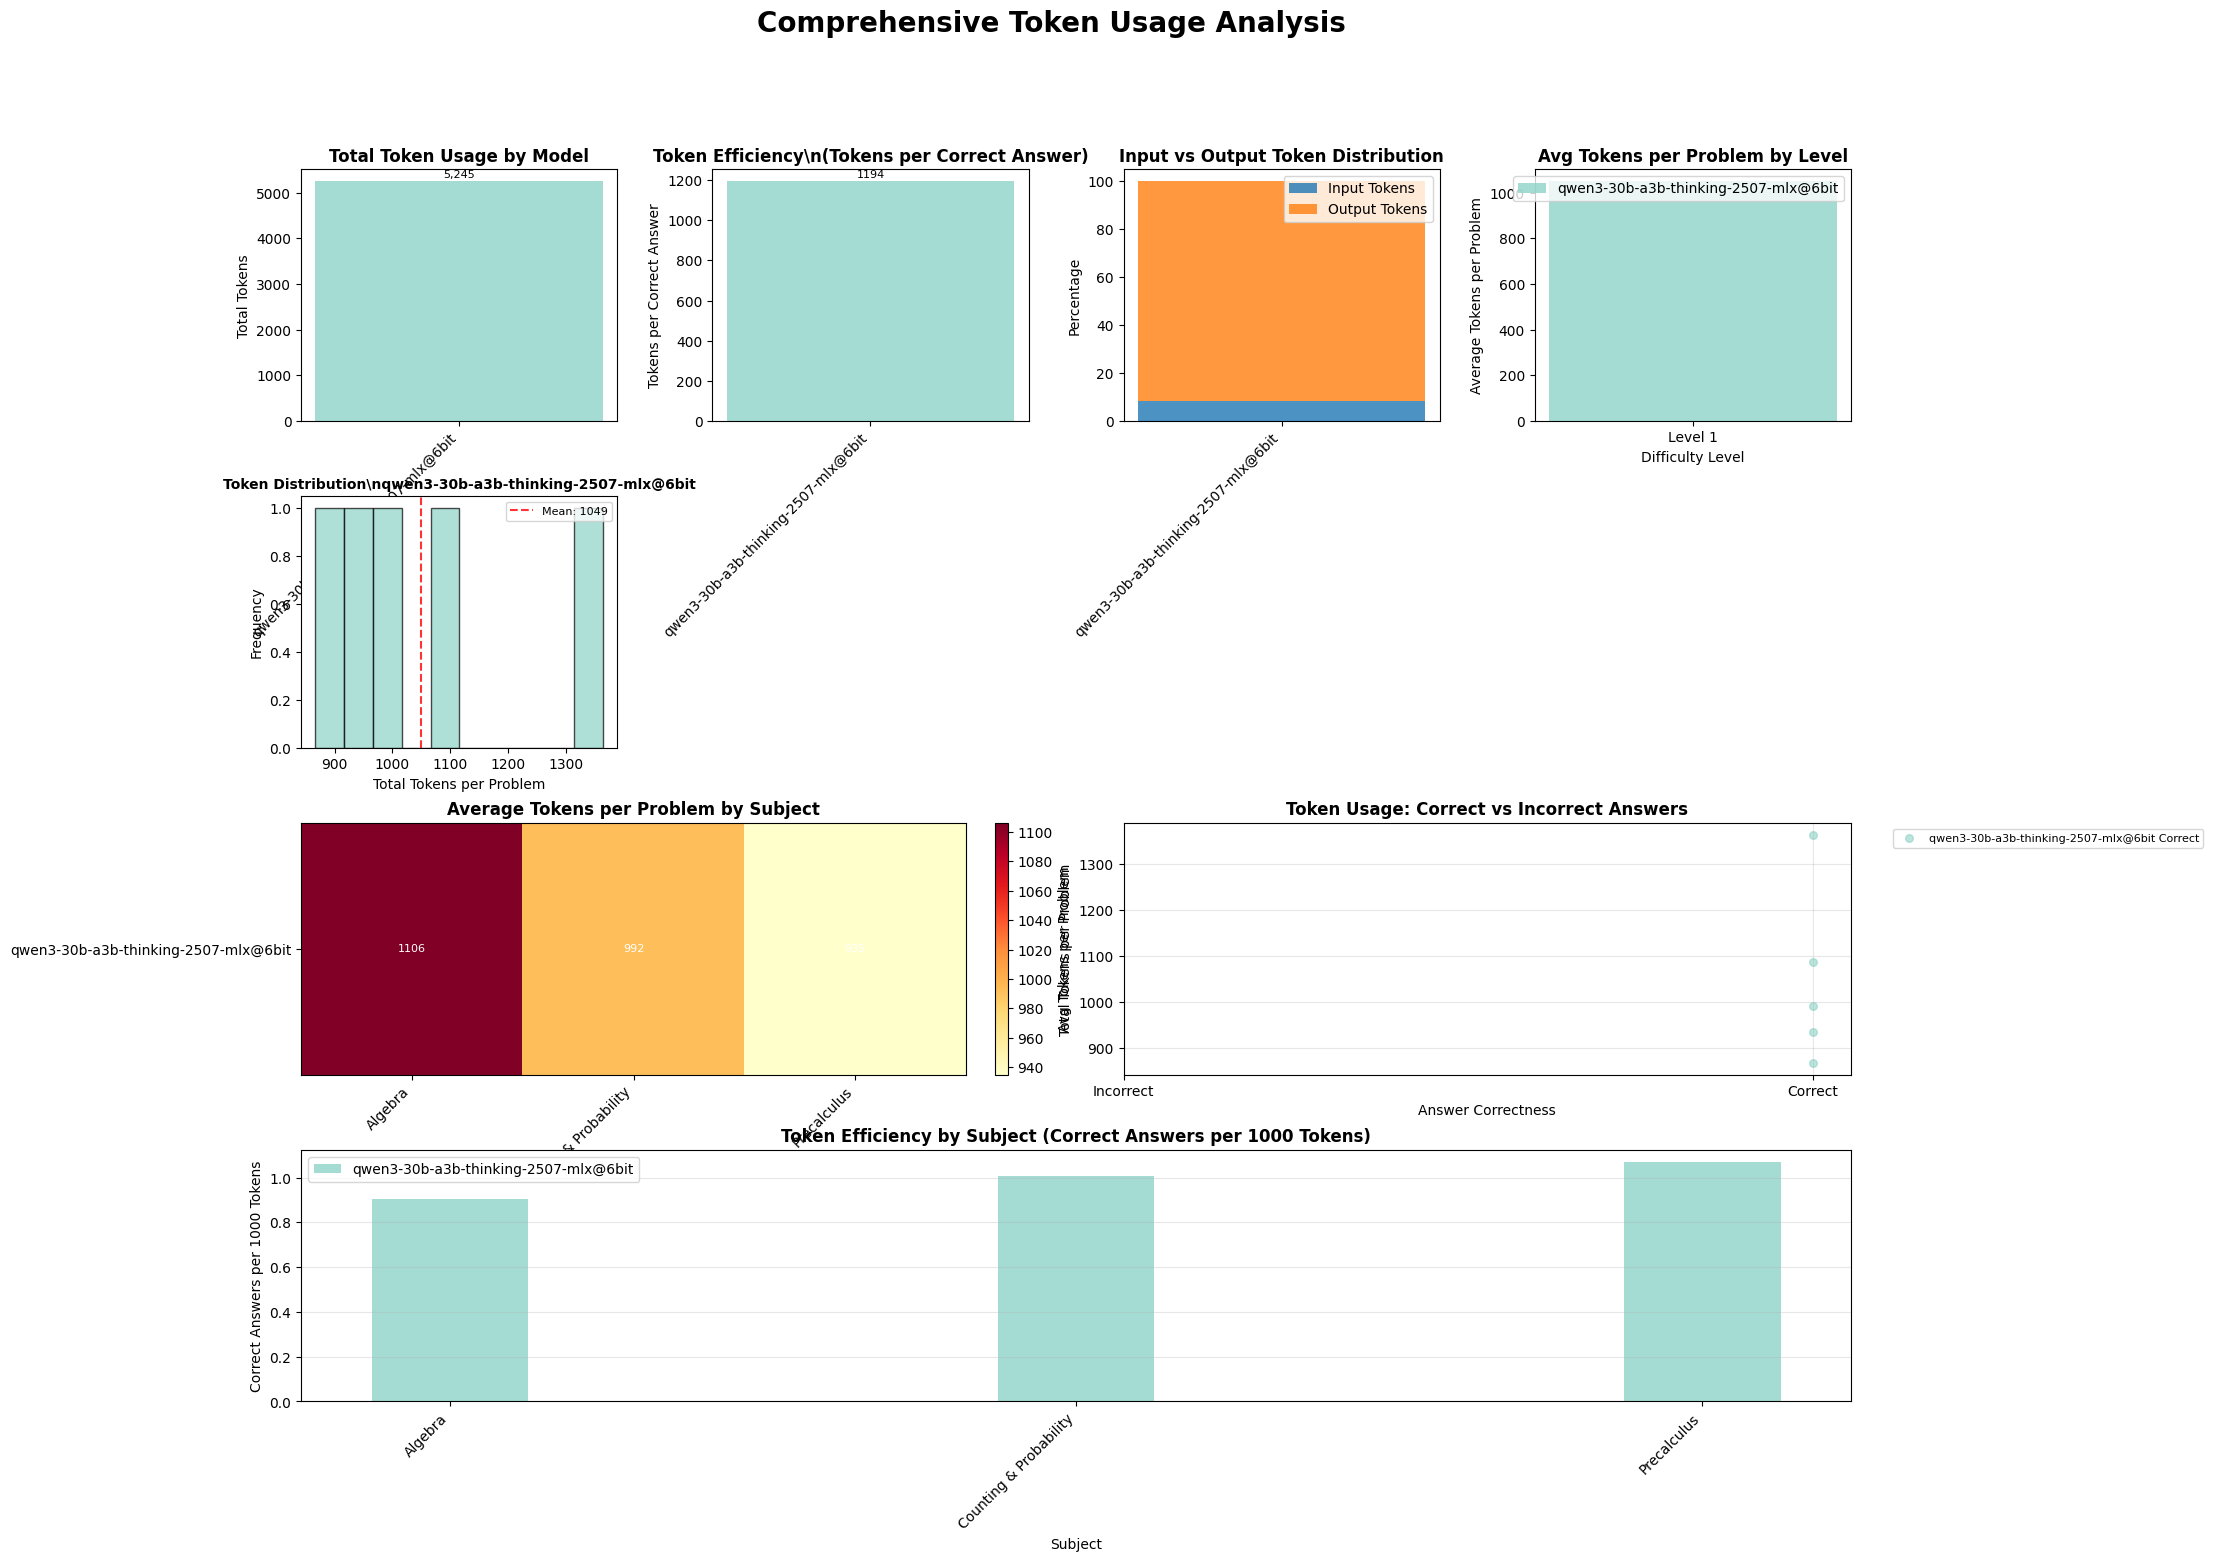

In [15]:
# Advanced Token Visualizations
if results:
    plt.style.use('default')
    
    # Create a comprehensive visualization dashboard
    n_models = len(results)
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    fig.suptitle('Comprehensive Token Usage Analysis', fontsize=20, fontweight='bold', y=0.98)
    
    model_names = list(results.keys())
    colors = plt.cm.Set3(np.linspace(0, 1, n_models))
    
    # 1. Overall Token Usage Comparison (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    token_totals = [results[name]['token_stats']['total_tokens'] for name in model_names]
    bars = ax1.bar(range(len(model_names)), token_totals, color=colors, alpha=0.8)
    ax1.set_title('Total Token Usage by Model', fontweight='bold')
    ax1.set_ylabel('Total Tokens')
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels([name.split('/')[-1] for name in model_names], rotation=45, ha='right')
    
    # Add values on bars
    for i, v in enumerate(token_totals):
        ax1.text(i, v + max(token_totals)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=8)
    
    # 2. Token Efficiency (Tokens per Correct Answer) (Top Center-Left)
    ax2 = fig.add_subplot(gs[0, 1])
    efficiencies = [results[name]['token_stats']['tokens_per_correct_answer'] for name in model_names]
    bars = ax2.bar(range(len(model_names)), efficiencies, color=colors, alpha=0.8)
    ax2.set_title('Token Efficiency\\n(Tokens per Correct Answer)', fontweight='bold')
    ax2.set_ylabel('Tokens per Correct Answer')
    ax2.set_xticks(range(len(model_names)))
    ax2.set_xticklabels([name.split('/')[-1] for name in model_names], rotation=45, ha='right')
    
    for i, v in enumerate(efficiencies):
        ax2.text(i, v + max(efficiencies)*0.01, f'{v:.0f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Input vs Output Token Ratio (Top Center-Right)
    ax3 = fig.add_subplot(gs[0, 2])
    input_ratios = []
    output_ratios = []
    for name in model_names:
        total = results[name]['token_stats']['total_tokens']
        input_pct = results[name]['token_stats']['total_input_tokens'] / total * 100
        output_pct = results[name]['token_stats']['total_output_tokens'] / total * 100
        input_ratios.append(input_pct)
        output_ratios.append(output_pct)
    
    width = 0.35
    x = np.arange(len(model_names))
    ax3.bar(x, input_ratios, width, label='Input Tokens', alpha=0.8)
    ax3.bar(x, output_ratios, width, bottom=input_ratios, label='Output Tokens', alpha=0.8)
    ax3.set_title('Input vs Output Token Distribution', fontweight='bold')
    ax3.set_ylabel('Percentage')
    ax3.set_xticks(x)
    ax3.set_xticklabels([name.split('/')[-1] for name in model_names], rotation=45, ha='right')
    ax3.legend()
    
    # 4. Token Usage by Difficulty Level (Top Right)
    ax4 = fig.add_subplot(gs[0, 3])
    all_levels = set()
    for result in results.values():
        all_levels.update(result['token_stats']['by_level'].keys())
    all_levels = sorted(all_levels)
    
    x = np.arange(len(all_levels))
    width = 0.35 if n_models == 2 else 0.25
    
    for i, model_name in enumerate(model_names):
        level_tokens = []
        for level in all_levels:
            if level in results[model_name]['token_stats']['by_level']:
                avg_tokens = results[model_name]['token_stats']['by_level'][level]['avg_tokens_per_problem']
                level_tokens.append(avg_tokens)
            else:
                level_tokens.append(0)
        
        offset = (i - n_models/2 + 0.5) * width
        ax4.bar(x + offset, level_tokens, width, label=model_name.split('/')[-1], alpha=0.8, color=colors[i])
    
    ax4.set_title('Avg Tokens per Problem by Level', fontweight='bold')
    ax4.set_ylabel('Average Tokens per Problem')
    ax4.set_xlabel('Difficulty Level')
    ax4.set_xticks(x)
    ax4.set_xticklabels([f'Level {level}' for level in all_levels])
    ax4.legend()
    
    # 5. Token Distribution Histograms (Second Row)
    for i, model_name in enumerate(model_names):
        ax = fig.add_subplot(gs[1, i])
        token_dist = results[model_name]['token_stats']['distribution']['total_tokens']
        if token_dist:
            ax.hist(token_dist, bins=10, alpha=0.7, color=colors[i], edgecolor='black')
            ax.set_title(f'Token Distribution\\n{model_name.split("/")[-1]}', fontweight='bold', fontsize=10)
            ax.set_xlabel('Total Tokens per Problem')
            ax.set_ylabel('Frequency')
            
            # Add statistics
            mean_tokens = np.mean(token_dist)
            ax.axvline(mean_tokens, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_tokens:.0f}')
            ax.legend(fontsize=8)
    
    # 6. Token Usage by Subject Heatmap (Third Row Left)
    ax6 = fig.add_subplot(gs[2, :2])
    
    # Get all subjects
    all_subjects = set()
    for result in results.values():
        all_subjects.update(result['token_stats']['by_subject'].keys())
    all_subjects = sorted(all_subjects)
    
    # Create heatmap data for token usage
    token_heatmap_data = []
    for model_name in model_names:
        row = []
        for subject in all_subjects:
            if subject in results[model_name]['token_stats']['by_subject']:
                avg_tokens = results[model_name]['token_stats']['by_subject'][subject]['avg_tokens_per_problem']
                row.append(avg_tokens)
            else:
                row.append(0)
        token_heatmap_data.append(row)
    
    im = ax6.imshow(token_heatmap_data, cmap='YlOrRd', aspect='auto')
    ax6.set_title('Average Tokens per Problem by Subject', fontweight='bold')
    ax6.set_xticks(range(len(all_subjects)))
    ax6.set_xticklabels(all_subjects, rotation=45, ha='right')
    ax6.set_yticks(range(len(model_names)))
    ax6.set_yticklabels([name.split('/')[-1] for name in model_names])
    
    # Add text annotations
    for i in range(len(model_names)):
        for j in range(len(all_subjects)):
            if token_heatmap_data[i][j] > 0:
                ax6.text(j, i, f'{token_heatmap_data[i][j]:.0f}', ha='center', va='center', 
                        color='white' if token_heatmap_data[i][j] > np.max(token_heatmap_data)/2 else 'black',
                        fontsize=8)
    
    cbar = plt.colorbar(im, ax=ax6, fraction=0.046, pad=0.04)
    cbar.set_label('Avg Tokens per Problem')
    
    # 7. Accuracy vs Token Efficiency Scatter Plot (Third Row Right)
    ax7 = fig.add_subplot(gs[2, 2:])
    
    # Collect data for all individual problems across all models
    for i, (model_name, result) in enumerate(results.items()):
        individual_results = result['individual_results']
        
        # Separate correct and incorrect answers
        correct_tokens = [r['token_usage']['total_tokens'] for r in individual_results if r['correct']]
        incorrect_tokens = [r['token_usage']['total_tokens'] for r in individual_results if not r['correct']]
        
        # Create scatter plot
        if correct_tokens:
            ax7.scatter([1] * len(correct_tokens), correct_tokens, 
                       alpha=0.6, s=30, color=colors[i], label=f'{model_name.split("/")[-1]} Correct')
        if incorrect_tokens:
            ax7.scatter([0] * len(incorrect_tokens), incorrect_tokens, 
                       alpha=0.6, s=30, color=colors[i], marker='x', label=f'{model_name.split("/")[-1]} Incorrect')
    
    ax7.set_title('Token Usage: Correct vs Incorrect Answers', fontweight='bold')
    ax7.set_xlabel('Answer Correctness')
    ax7.set_ylabel('Total Tokens per Problem')
    ax7.set_xticks([0, 1])
    ax7.set_xticklabels(['Incorrect', 'Correct'])
    ax7.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax7.grid(True, alpha=0.3)
    
    # 8. Token Efficiency by Subject (Bottom Row)
    ax8 = fig.add_subplot(gs[3, :])
    
    # Calculate token efficiency (correct answers per 1000 tokens) by subject
    subject_efficiency_data = []
    
    for subject in all_subjects:
        efficiency_by_model = []
        for model_name in model_names:
            if subject in results[model_name]['token_stats']['by_subject']:
                subject_stats = results[model_name]['token_stats']['by_subject'][subject]
                if subject_stats['total_tokens'] > 0 and subject_stats['correct_problems'] > 0:
                    efficiency = (subject_stats['correct_problems'] / subject_stats['total_tokens']) * 1000
                else:
                    efficiency = 0
                efficiency_by_model.append(efficiency)
            else:
                efficiency_by_model.append(0)
        subject_efficiency_data.append(efficiency_by_model)
    
    x = np.arange(len(all_subjects))
    width = 0.35 if n_models == 2 else 0.25
    
    for i, model_name in enumerate(model_names):
        efficiencies = [subject_efficiency_data[j][i] for j in range(len(all_subjects))]
        offset = (i - n_models/2 + 0.5) * width
        ax8.bar(x + offset, efficiencies, width, label=model_name.split('/')[-1], 
               alpha=0.8, color=colors[i])
    
    ax8.set_title('Token Efficiency by Subject (Correct Answers per 1000 Tokens)', fontweight='bold')
    ax8.set_ylabel('Correct Answers per 1000 Tokens')
    ax8.set_xlabel('Subject')
    ax8.set_xticks(x)
    ax8.set_xticklabels(all_subjects, rotation=45, ha='right')
    ax8.legend()
    ax8.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No results available for token visualization.")

## Advanced Token Visualizations

Comprehensive visual analysis of token usage patterns and efficiency metrics:

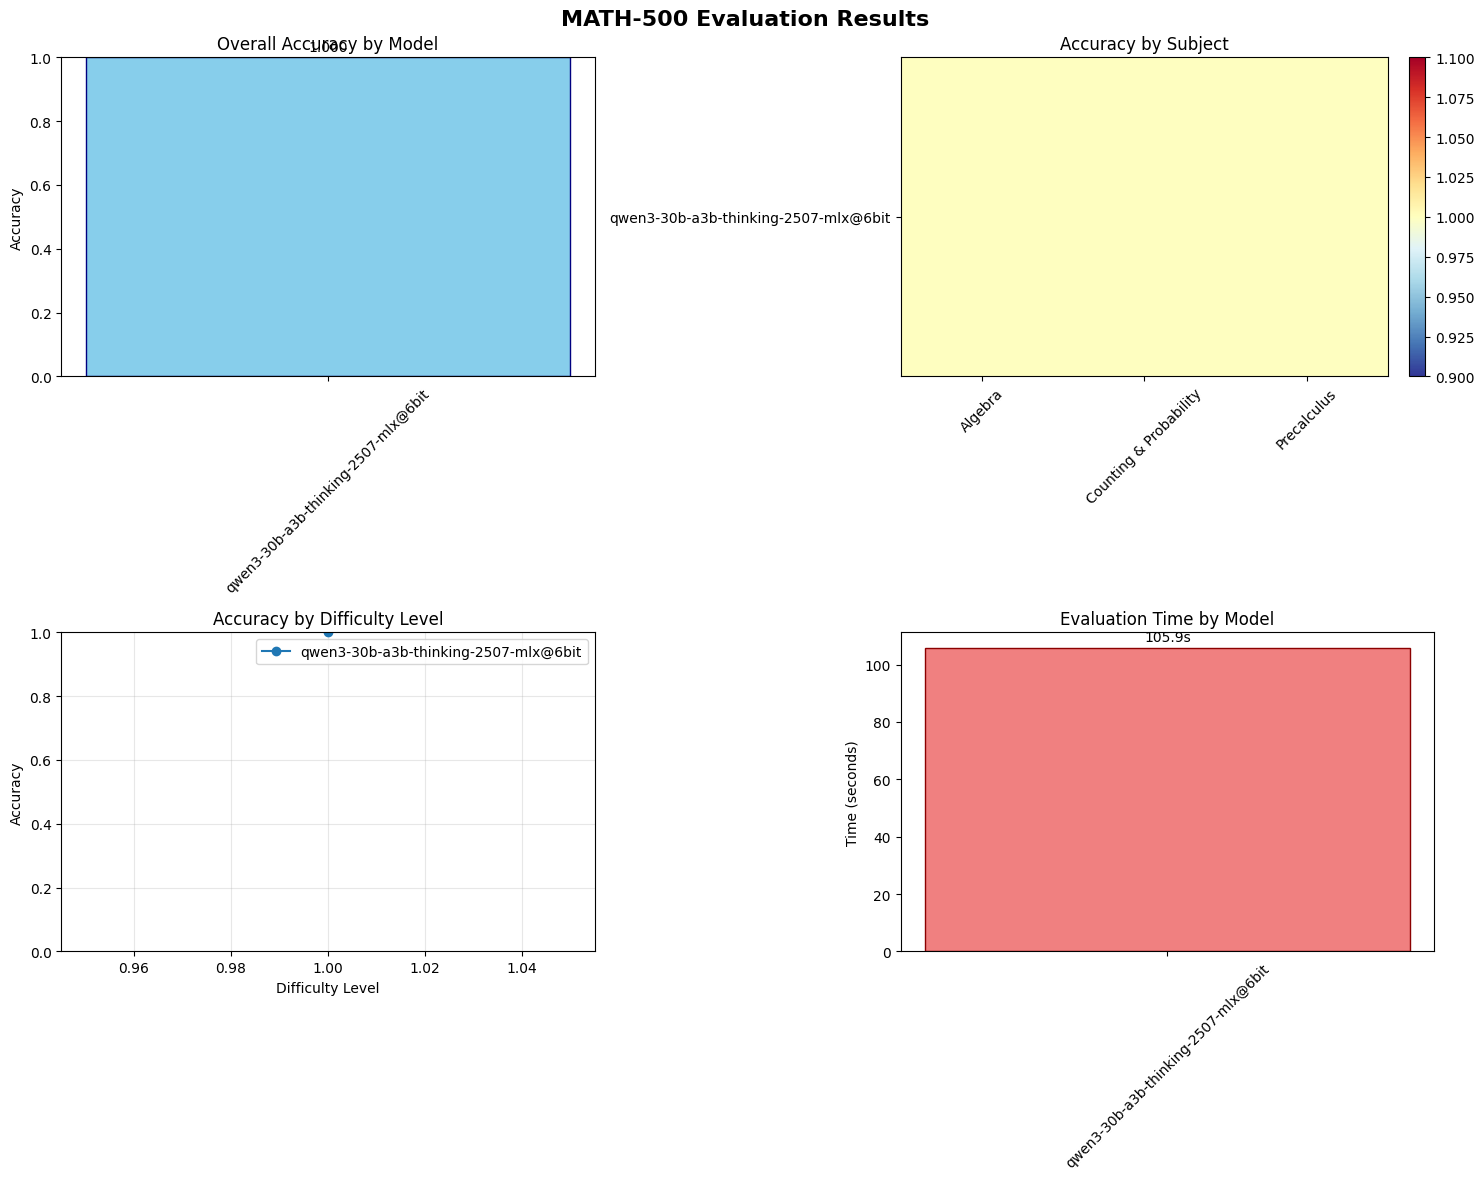

In [16]:
# Create visualizations
if results:
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('MATH-500 Evaluation Results', fontsize=16, fontweight='bold')
    
    # Overall accuracy comparison
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    
    axes[0, 0].bar(model_names, accuracies, color='skyblue', edgecolor='navy')
    axes[0, 0].set_title('Overall Accuracy by Model')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].set_ylim(0, 1)
    
    # Add accuracy values on bars
    for i, v in enumerate(accuracies):
        axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Subject-wise performance heatmap
    if len(results) > 0:
        # Get all subjects
        all_subjects = set()
        for result in results.values():
            all_subjects.update(result['by_subject'].keys())
        all_subjects = sorted(all_subjects)
        
        # Create heatmap data
        heatmap_data = []
        for model_name in model_names:
            row = []
            for subject in all_subjects:
                if subject in results[model_name]['by_subject']:
                    row.append(results[model_name]['by_subject'][subject]['accuracy'])
                else:
                    row.append(0)
            heatmap_data.append(row)
        
        im = axes[0, 1].imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
        axes[0, 1].set_title('Accuracy by Subject')
        axes[0, 1].set_xticks(range(len(all_subjects)))
        axes[0, 1].set_xticklabels(all_subjects, rotation=45)
        axes[0, 1].set_yticks(range(len(model_names)))
        axes[0, 1].set_yticklabels(model_names)
        
        # Add colorbar
        plt.colorbar(im, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Level-wise performance
    if len(results) > 0:
        levels = sorted(set().union(*[result['by_level'].keys() for result in results.values()]))
        
        for model_name in model_names:
            level_accuracies = []
            for level in levels:
                if level in results[model_name]['by_level']:
                    level_accuracies.append(results[model_name]['by_level'][level]['accuracy'])
                else:
                    level_accuracies.append(0)
            axes[1, 0].plot(levels, level_accuracies, marker='o', label=model_name)
        
        axes[1, 0].set_title('Accuracy by Difficulty Level')
        axes[1, 0].set_xlabel('Difficulty Level')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_ylim(0, 1)
    
    # Evaluation time comparison
    eval_times = [results[name]['evaluation_time'] for name in model_names]
    axes[1, 1].bar(model_names, eval_times, color='lightcoral', edgecolor='darkred')
    axes[1, 1].set_title('Evaluation Time by Model')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add time values on bars
    for i, v in enumerate(eval_times):
        axes[1, 1].text(i, v + max(eval_times)*0.01, f'{v:.1f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("No results available for visualization.")

## Detailed Analysis

In [17]:
# Enhanced Results Export with Token Statistics
if results:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 1. Save comprehensive results to JSON
    filename = f"math_500_evaluation_results_{timestamp}.json"
    evaluator.save_results(filename)
    
    # 2. Save token summary CSV
    token_summary_df = evaluator.get_token_summary()
    token_summary_filename = f"math_500_token_summary_{timestamp}.csv"
    token_summary_df.to_csv(token_summary_filename, index=False)
    print(f"Token summary saved to {token_summary_filename}")
    
    # 3. Save detailed per-problem results with token data
    detailed_results = []
    for model_name, result in results.items():
        for individual_result in result['individual_results']:
            detailed_results.append({
                'model_name': model_name,
                'problem_id': individual_result['problem_id'],
                'subject': individual_result['subject'],
                'level': individual_result['level'],
                'correct': individual_result['correct'],
                'input_tokens': individual_result['token_usage']['input_tokens'],
                'output_tokens': individual_result['token_usage']['output_tokens'],
                'total_tokens': individual_result['token_usage']['total_tokens'],
                'prompt_length': individual_result['prompt_length'],
                'response_length': individual_result['response_length'],
                'expected_answer': individual_result['expected_answer'],
                'predicted_answer': individual_result['predicted_answer'],
                'problem_text': individual_result['problem'][:200] + '...' if len(individual_result['problem']) > 200 else individual_result['problem']
            })
    
    detailed_df = pd.DataFrame(detailed_results)
    detailed_filename = f"math_500_detailed_results_{timestamp}.csv"
    detailed_df.to_csv(detailed_filename, index=False)
    print(f"Detailed results with token data saved to {detailed_filename}")
    
    # 4. Save token statistics by category
    category_stats = []
    
    for model_name, result in results.items():
        token_stats = result['token_stats']
        
        # By level statistics
        for level, stats in token_stats['by_level'].items():
            category_stats.append({
                'model_name': model_name,
                'category_type': 'level',
                'category_value': f'Level {level}',
                'problems': stats['problems'],
                'correct_problems': stats['correct_problems'],
                'accuracy': stats['correct_problems'] / stats['problems'] if stats['problems'] > 0 else 0,
                'total_tokens': stats['total_tokens'],
                'avg_tokens_per_problem': stats['avg_tokens_per_problem'],
                'tokens_per_correct': stats['tokens_per_correct'] if stats['correct_problems'] > 0 else 0
            })
        
        # By subject statistics
        for subject, stats in token_stats['by_subject'].items():
            category_stats.append({
                'model_name': model_name,
                'category_type': 'subject',
                'category_value': subject,
                'problems': stats['problems'],
                'correct_problems': stats['correct_problems'],
                'accuracy': stats['correct_problems'] / stats['problems'] if stats['problems'] > 0 else 0,
                'total_tokens': stats['total_tokens'],
                'avg_tokens_per_problem': stats['avg_tokens_per_problem'],
                'tokens_per_correct': stats['tokens_per_correct'] if stats['correct_problems'] > 0 else 0
            })
        
        # By correctness statistics
        for correctness, stats in token_stats['by_correctness'].items():
            if stats['problems'] > 0:
                category_stats.append({
                    'model_name': model_name,
                    'category_type': 'correctness',
                    'category_value': correctness,
                    'problems': stats['problems'],
                    'correct_problems': stats['problems'] if correctness == 'correct' else 0,
                    'accuracy': 1.0 if correctness == 'correct' else 0.0,
                    'total_tokens': stats['total_tokens'],
                    'avg_tokens_per_problem': stats['total_tokens'] / stats['problems'],
                    'tokens_per_correct': 0  # Not applicable for this breakdown
                })
    
    category_df = pd.DataFrame(category_stats)
    category_filename = f"math_500_token_stats_by_category_{timestamp}.csv"
    category_df.to_csv(category_filename, index=False)
    print(f"Token statistics by category saved to {category_filename}")
    
    # 5. Save token distribution statistics
    distribution_stats = []
    for model_name, result in results.items():
        token_stats = result['token_stats']
        
        for token_type in ['input_tokens', 'output_tokens', 'total_tokens']:
            if f'{token_type}_percentiles' in token_stats:
                percentiles = token_stats[f'{token_type}_percentiles']
                distribution_stats.append({
                    'model_name': model_name,
                    'token_type': token_type,
                    'min': percentiles['min'],
                    'p25': percentiles['p25'],
                    'p50': percentiles['p50'],
                    'p75': percentiles['p75'],
                    'p90': percentiles['p90'],
                    'p95': percentiles['p95'],
                    'max': percentiles['max'],
                    'std': percentiles['std']
                })
    
    if distribution_stats:
        distribution_df = pd.DataFrame(distribution_stats)
        distribution_filename = f"math_500_token_distributions_{timestamp}.csv"
        distribution_df.to_csv(distribution_filename, index=False)
        print(f"Token distribution statistics saved to {distribution_filename}")
    
    # 6. Create a comprehensive report text file
    report_filename = f"math_500_evaluation_report_{timestamp}.txt"
    with open(report_filename, 'w') as report_file:
        report_file.write("MATH-500 EVALUATION REPORT\\n")
        report_file.write("=" * 50 + "\\n\\n")
        report_file.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n")
        report_file.write(f"Total problems evaluated: {len(df) if 'df' in globals() else 'Unknown'}\\n")
        report_file.write(f"Models evaluated: {len(results)}\\n\\n")
        
        for model_name, result in results.items():
            report_file.write(f"MODEL: {model_name}\\n")
            report_file.write("-" * 40 + "\\n")
            report_file.write(f"Accuracy: {result['accuracy']:.3f} ({result['correct_answers']}/{result['total_problems']})\\n")
            report_file.write(f"Evaluation time: {result['evaluation_time']:.2f} seconds\\n")
            
            token_stats = result['token_stats']
            report_file.write(f"Total tokens: {token_stats['total_tokens']:,}\\n")
            report_file.write(f"Avg tokens per problem: {token_stats['avg_total_tokens']:.1f}\\n")
            report_file.write(f"Tokens per correct answer: {token_stats['tokens_per_correct_answer']:.1f}\\n")
            report_file.write(f"Tokens per second: {token_stats['tokens_per_second']:.1f}\\n")
            
            report_file.write("\\nPerformance by Level:\\n")
            for level in sorted(result['by_level'].keys()):
                level_data = result['by_level'][level]
                level_tokens = token_stats['by_level'][level]
                report_file.write(f"  Level {level}: {level_data['accuracy']:.3f} accuracy, "
                                f"{level_tokens['avg_tokens_per_problem']:.1f} avg tokens\\n")
            
            report_file.write("\\nPerformance by Subject:\\n")
            for subject in sorted(result['by_subject'].keys()):
                subject_data = result['by_subject'][subject]
                subject_tokens = token_stats['by_subject'][subject]
                report_file.write(f"  {subject}: {subject_data['accuracy']:.3f} accuracy, "
                                f"{subject_tokens['avg_tokens_per_problem']:.1f} avg tokens\\n")
            
            report_file.write("\\n" + "=" * 50 + "\\n\\n")
    
    print(f"Comprehensive report saved to {report_filename}")
    
    print(f"\\n🎉 EVALUATION COMPLETED SUCCESSFULLY!")
    print(f"📁 Files generated:")
    print(f"   - {filename} (Complete results JSON)")
    print(f"   - {token_summary_filename} (Token summary CSV)")
    print(f"   - {detailed_filename} (Detailed per-problem results)")
    print(f"   - {category_filename} (Token stats by category)")
    if distribution_stats:
        print(f"   - {distribution_filename} (Token distribution statistics)")
    print(f"   - {report_filename} (Human-readable report)")
    
else:
    print("No results to save. Please check model availability and try again.")

Results saved to math_500_evaluation_results_20250730_215021.json
Token summary saved to math_500_token_summary_20250730_215021.csv
Detailed results with token data saved to math_500_detailed_results_20250730_215021.csv
Token statistics by category saved to math_500_token_stats_by_category_20250730_215021.csv
Token distribution statistics saved to math_500_token_distributions_20250730_215021.csv
Comprehensive report saved to math_500_evaluation_report_20250730_215021.txt
\n🎉 EVALUATION COMPLETED SUCCESSFULLY!
📁 Files generated:
   - math_500_evaluation_results_20250730_215021.json (Complete results JSON)
   - math_500_token_summary_20250730_215021.csv (Token summary CSV)
   - math_500_detailed_results_20250730_215021.csv (Detailed per-problem results)
   - math_500_token_stats_by_category_20250730_215021.csv (Token stats by category)
   - math_500_token_distributions_20250730_215021.csv (Token distribution statistics)
   - math_500_evaluation_report_20250730_215021.txt (Human-readable 

## Save Results

In [18]:
# Save results to file
if results:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"math_500_evaluation_results_{timestamp}.json"
    evaluator.save_results(filename)
    
    # Also save a summary CSV
    summary_data = []
    for model_name, result in results.items():
        summary_data.append({
            'model_name': model_name,
            'accuracy': result['accuracy'],
            'correct_answers': result['correct_answers'],
            'total_problems': result['total_problems'],
            'evaluation_time': result['evaluation_time']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_filename = f"math_500_summary_{timestamp}.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"Summary saved to {summary_filename}")
    
    print(f"\nEvaluation completed successfully!")
    print(f"Results saved to: {filename}")
    print(f"Summary saved to: {summary_filename}")
else:
    print("No results to save. Please check model availability and try again.")

Results saved to math_500_evaluation_results_20250730_215021.json
Summary saved to math_500_summary_20250730_215021.csv

Evaluation completed successfully!
Results saved to: math_500_evaluation_results_20250730_215021.json
Summary saved to: math_500_summary_20250730_215021.csv
